<a href="https://colab.research.google.com/github/Yuto-Kishi/ECHONET-Lite/blob/main/untitled37.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


📥 Loading Living data from: /content/リビング.csv ...
Resampling to 1min...
Building features...

  [Living] Analysis
  Features: 638
  Test Label Dist: {0: 6901, 2: 333, 1: 326}

--- Result: Living ---
              precision    recall  f1-score   support

           0      0.997     0.983     0.990      6901
           1      0.764     0.896     0.825       326
           2      0.717     0.799     0.756       333

    accuracy                          0.972      7560
   macro avg      0.826     0.893     0.857      7560
weighted avg      0.975     0.972     0.973      7560



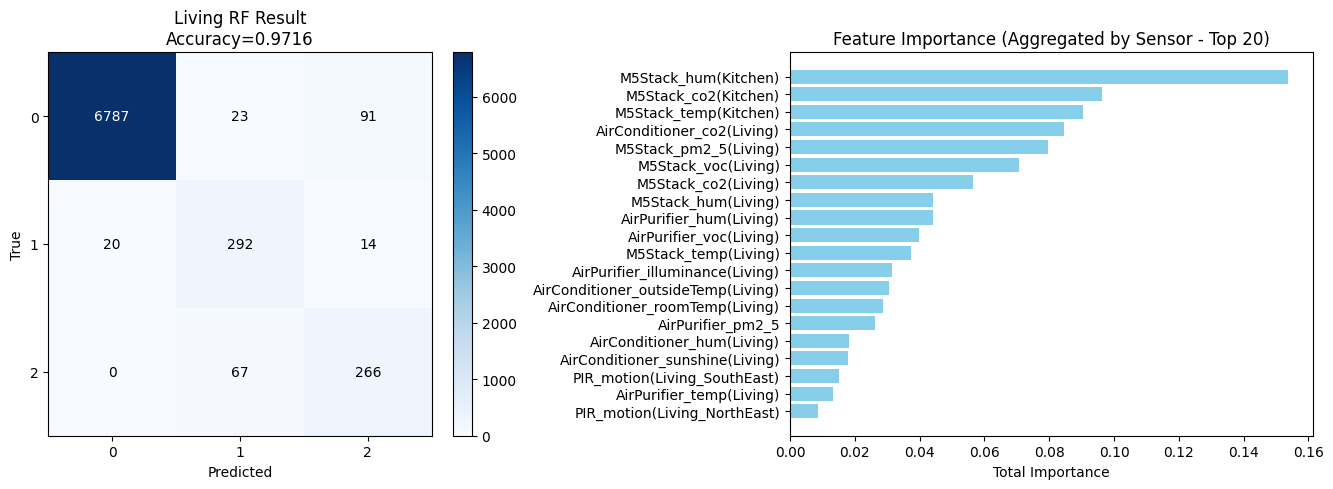


--- Top 20 Feature Importances (Aggregated by Sensor) ---
feature
M5Stack_hum(Kitchen)                  0.153572
M5Stack_co2(Kitchen)                  0.096361
M5Stack_temp(Kitchen)                 0.090302
AirConditioner_co2(Living)            0.084623
M5Stack_pm2_5(Living)                 0.079720
M5Stack_voc(Living)                   0.070727
M5Stack_co2(Living)                   0.056572
M5Stack_hum(Living)                   0.044166
AirPurifier_hum(Living)               0.044059
AirPurifier_voc(Living)               0.039823
M5Stack_temp(Living)                  0.037280
AirPurifier_illuminance(Living)       0.031528
AirConditioner_outsideTemp(Living)    0.030427
AirConditioner_roomTemp(Living)       0.028613
AirPurifier_pm2_5                     0.026386
AirConditioner_hum(Living)            0.018190
AirConditioner_sunshine(Living)       0.017947
PIR_motion(Living_SouthEast)          0.015078
AirPurifier_temp(Living)              0.013368
PIR_motion(Living_NorthEast)          0.

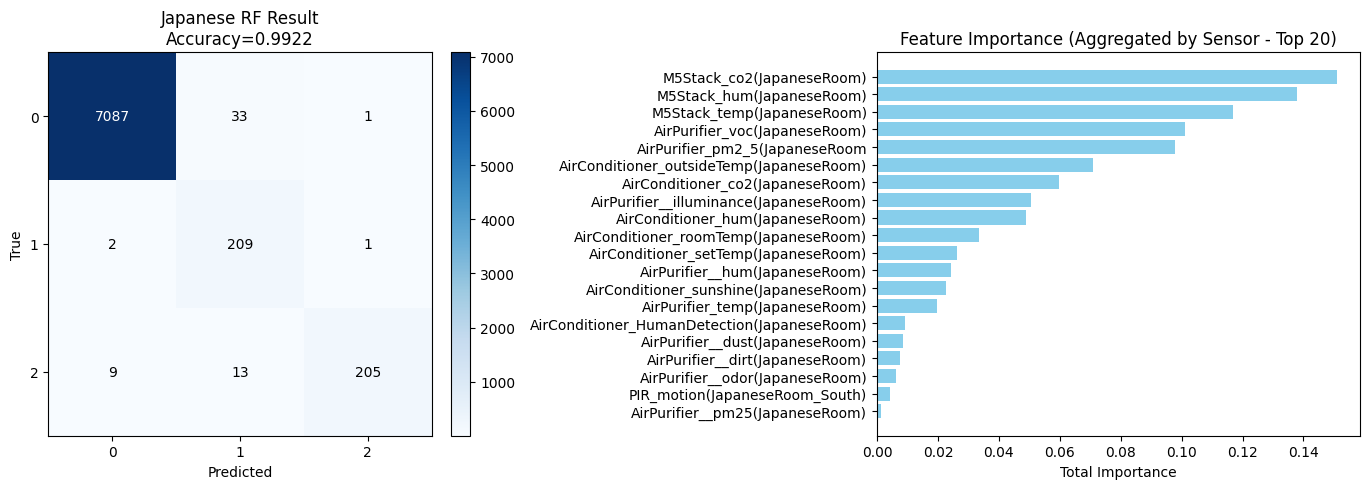


--- Top 20 Feature Importances (Aggregated by Sensor) ---
feature
M5Stack_co2(JapaneseRoom)                      0.151076
M5Stack_hum(JapaneseRoom)                      0.138045
M5Stack_temp(JapaneseRoom)                     0.116939
AirPurifier_voc(JapaneseRoom)                  0.100992
AirPurifier_pm2_5(JapaneseRoom                 0.097690
AirConditioner_outsideTemp(JapaneseRoom)       0.070786
AirConditioner_co2(JapaneseRoom)               0.059733
AirPurifier__illuminance(JapaneseRoom)         0.050661
AirConditioner_hum(JapaneseRoom)               0.048800
AirConditioner_roomTemp(JapaneseRoom)          0.033319
AirConditioner_setTemp(JapaneseRoom)           0.026415
AirPurifier__hum(JapaneseRoom)                 0.024178
AirConditioner_sunshine(JapaneseRoom)          0.022681
AirPurifier_temp(JapaneseRoom)                 0.019744
AirConditioner_HumanDetection(JapaneseRoom)    0.009105
AirPurifier__dust(JapaneseRoom)                0.008580
AirPurifier__dirt(JapaneseRoom)      

In [ ]:
# ============================================================
# Room-Specific Analysis (Sensor Aggregated Importance)
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =========================
# Config
# =========================
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

WINS = [5, 10, 15, 20, 25, 30, 60]
TOPK_IMPORTANCE = 20
SEED = 42

BLOCK_MINUTES = 30
TEST_RATIO = 0.30

# 判定ロジック用定数 (表示は抑制)
THRESHOLD = 0.3

LABEL_COLS = [
    "Label_Living_Action",
    "Label_Living_Count",
    "Label_Japanese_Count",
    "Label_Japanese_Action",
    "Label_Total_People"
]

# =========================
# Utilities
# =========================
def fix_timestamp_robust(df: pd.DataFrame, col: str) -> pd.Series:
    s = df[col].astype(str)
    if s.iloc[0].startswith("20") and "-" in s.iloc[0]:
        return pd.to_datetime(s, errors="coerce")
    try:
        temp_dates = pd.to_datetime(s, format='%M:%S.%f', errors='coerce')
    except:
        temp_dates = pd.to_datetime(s, errors='coerce')
    if temp_dates.isna().mean() > 0.5:
         temp_dates = pd.to_datetime(s, errors='coerce')
    diff = temp_dates.diff()
    wrap_indices = diff < pd.Timedelta(minutes=-30)
    hours_to_add = wrap_indices.cumsum()
    return temp_dates + pd.to_timedelta(hours_to_add, unit='h')

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]
    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())
    dfr = pd.concat(out, axis=1).sort_index()
    return safe_ffill(dfr).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

# ---------------------------------------------------------
# Feature Importance Aggregation Logic
# ---------------------------------------------------------
def aggregate_importances(feature_names, importances):
    """
    特徴量名からサフィックス(_diff, _mean_XX, _std_XX, _slope_XX, _sum_XX)を取り除き、
    ベースとなるセンサー名ごとに重要度を合計する。
    """
    base_names = []
    # 正規表現で末尾の派生パターンを削除
    pattern = re.compile(r'(_diff|_mean_\d+|_std_\d+|_slope_\d+|_sum_\d+)$')

    for name in feature_names:
        base = pattern.sub('', name)
        base_names.append(base)

    df_imp = pd.DataFrame({
        'feature': base_names,
        'importance': importances
    })

    # ベース名でグループ化して合計
    grouped = df_imp.groupby('feature')['importance'].sum().sort_values(ascending=False)
    return grouped

def plot_cm_and_importance_aggregated(title, y_true, y_pred, labels, feature_names, importances, topk=20):
    """
    重要度を集約してプロットするバージョン (Threshold表記なし)
    """
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Aggregation
    agg_imp = aggregate_importances(feature_names, importances)

    fig = plt.figure(figsize=(14, 5))

    # Confusion Matrix
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Blues")
    ax1.set_title(f"{title}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(labels); ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = "white" if cm[i, j] > cm.max()/2 else "black"
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color=text_color)

    # Aggregated Importance Plot
    ax2 = plt.subplot(1, 2, 2)
    top = agg_imp.head(topk)[::-1] # Top K extraction for plotting
    ax2.barh(top.index, top.values, color="skyblue")
    ax2.set_title(f"Feature Importance (Aggregated by Sensor - Top {topk})")
    ax2.set_xlabel("Total Importance")

    plt.tight_layout()
    plt.show()

def print_top_features_aggregated(feature_names, importances, topk=20):
    agg_imp = aggregate_importances(feature_names, importances)
    print(f"\n--- Top {topk} Feature Importances (Aggregated by Sensor) ---")
    print(agg_imp.head(topk))

# =========================
# Feature Engineering
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3: return pd.Series(0.0, index=y.index)
    t = np.arange(w, dtype=float)
    t_centered = t - t.mean()
    denom = np.sum(t_centered ** 2)
    if denom == 0: return pd.Series(0.0, index=y.index)
    def slope_fn(a):
        a = np.asarray(a, dtype=float)
        return np.dot(t_centered, (a - a.mean())) / denom
    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def build_numeric_features_multiwin(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns: continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)
        feats[c] = s
        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff"] = d1
        for w in wins:
            feats[f"{c}_mean_{w}"] = s.rolling(w).mean().fillna(0.0)
            feats[f"{c}_std_{w}"]  = s.rolling(w).std().fillna(0.0)
            feats[f"{c}_slope_{w}"] = _rolling_linreg_slope(s, w)
    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X.loc[:, ~X.columns.duplicated()]

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns: continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}"] = s.rolling(w).sum().fillna(0.0)
    X = pd.DataFrame(feats, index=df.index)
    return X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# =========================
# Main Logic
# =========================
def rf_model():
    return RandomForestClassifier(
        n_estimators=800,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=2,
    )

def run_room_file_analysis(filename: str, room: str, target_col: str):
    print(f"\n📥 Loading {room} data from: {filename} ...")
    try:
        df0 = pd.read_csv(filename, low_memory=False)
    except UnicodeDecodeError:
        df0 = pd.read_csv(filename, low_memory=False, encoding='cp932')

    if TIME_COL not in df0.columns:
        print(f"Error: CSVに {TIME_COL} 列がありません。")
        return
    if target_col not in df0.columns:
        print(f"Error: ラベル列 {target_col} がありません。")
        return

    df0[TIME_COL] = fix_timestamp_robust(df0, TIME_COL)
    df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)
    df0 = safe_ffill(df0).fillna(0.0)

    print("Resampling to 1min...")
    df = resample_1min(df0, RESAMPLE_RULE)

    y = pd.to_numeric(df[target_col], errors="coerce").fillna(0).astype(int)
    y = y.where(y.isin([0, 1, 2]), 0)

    # All non-label columns as features
    all_cols = [c for c in df.columns if c not in LABEL_COLS]
    hum_cols = [c for c in all_cols if c.lower().endswith("_human") or "PIR" in c]
    num_cols = [c for c in all_cols if c not in hum_cols]

    print("Building features...")
    X_num = build_numeric_features_multiwin(df, num_cols, WINS)
    X_hum = build_human_features(df, hum_cols, WINS)
    X = pd.concat([X_num, X_hum], axis=1).fillna(0.0)

    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_te, y_te = X.iloc[te_idx], y.iloc[te_idx]

    print("\n" + "=" * 80)
    print(f"  [{room}] Analysis")
    print(f"  Features: {X.shape[1]}")
    print(f"  Test Label Dist: {y_te.value_counts().to_dict()}")
    print("=" * 80)

    model = rf_model()
    model.fit(X_tr, y_tr)

    # --- 閾値適用ロジック (内部処理) ---
    probs = model.predict_proba(X_te)
    classes = model.classes_

    final_pred = []
    for p in probs:
        c_probs = {c: val for c, val in zip(classes, p)}
        candidates = {c: val for c, val in c_probs.items() if c != 0 and val >= THRESHOLD}
        if candidates:
            best_c = max(candidates, key=candidates.get)
            final_pred.append(best_c)
        else:
            final_pred.append(0)
    final_pred = np.array(final_pred)
    # ---------------------------

    print(f"\n--- Result: {room} ---")
    print(classification_report(y_te, final_pred, digits=3, zero_division=0))

    # Plot and Print Aggregated Importance
    plot_cm_and_importance_aggregated(
        f"{room} RF Result",
        y_te, final_pred, [0, 1, 2],
        X.columns, model.feature_importances_
    )
    print_top_features_aggregated(X.columns, model.feature_importances_, TOPK_IMPORTANCE)

# =========================
# Main
# =========================
if __name__ == "__main__":
    # ファイル名が正しいことを確認して実行してください
    try:
        run_room_file_analysis("/content/リビング.csv", "Living", "Label_Living_Count")
        run_room_file_analysis("/content/和室.csv", "Japanese", "Label_Japanese_Count")
    except FileNotFoundError:
        print("\n⚠️ ファイルが見つかりません。ファイルパスを確認してください。")
    print("\n✅ Done.")


📥 Loading Living data from: /content/リビング.csv ...
Resampling to 1min...
Building features...

  [Living] Analysis
  Features: 661
  Test Label Dist: {0: 6901, 2: 333, 1: 326}

--- Result: Living ---
              precision    recall  f1-score   support

           0      0.995     0.991     0.993      6901
           1      0.804     0.893     0.846       326
           2      0.821     0.799     0.810       333

    accuracy                          0.979      7560
   macro avg      0.873     0.894     0.883      7560
weighted avg      0.979     0.979     0.979      7560



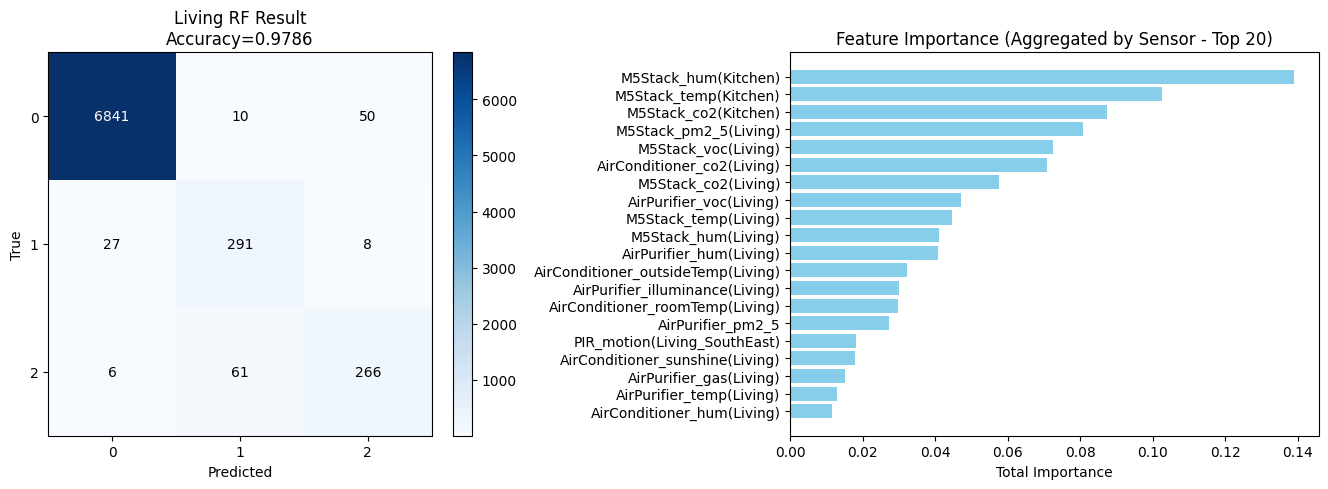


--- Top 20 Feature Importances (Aggregated by Sensor) ---
feature
M5Stack_hum(Kitchen)                  0.138903
M5Stack_temp(Kitchen)                 0.102431
M5Stack_co2(Kitchen)                  0.087427
M5Stack_pm2_5(Living)                 0.080747
M5Stack_voc(Living)                   0.072389
AirConditioner_co2(Living)            0.070727
M5Stack_co2(Living)                   0.057619
AirPurifier_voc(Living)               0.046986
M5Stack_temp(Living)                  0.044719
M5Stack_hum(Living)                   0.040956
AirPurifier_hum(Living)               0.040830
AirConditioner_outsideTemp(Living)    0.032189
AirPurifier_illuminance(Living)       0.030093
AirConditioner_roomTemp(Living)       0.029698
AirPurifier_pm2_5                     0.027180
PIR_motion(Living_SouthEast)          0.018228
AirConditioner_sunshine(Living)       0.017709
AirPurifier_gas(Living)               0.015026
AirPurifier_temp(Living)              0.012782
AirConditioner_hum(Living)            0.

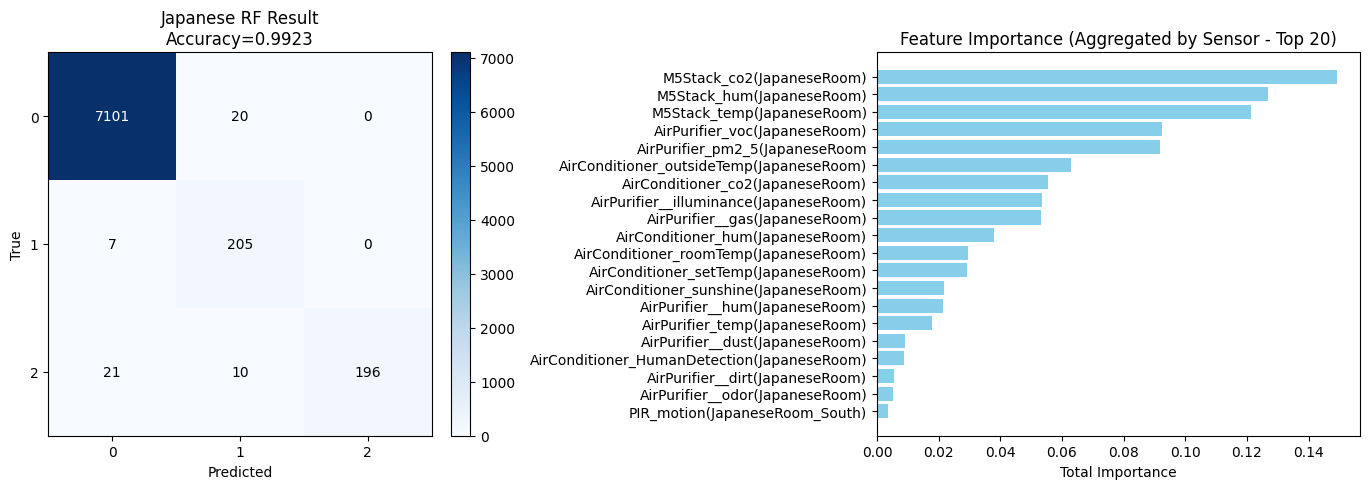


--- Top 20 Feature Importances (Aggregated by Sensor) ---
feature
M5Stack_co2(JapaneseRoom)                      0.149284
M5Stack_hum(JapaneseRoom)                      0.126883
M5Stack_temp(JapaneseRoom)                     0.121475
AirPurifier_voc(JapaneseRoom)                  0.092551
AirPurifier_pm2_5(JapaneseRoom                 0.091654
AirConditioner_outsideTemp(JapaneseRoom)       0.062826
AirConditioner_co2(JapaneseRoom)               0.055579
AirPurifier__illuminance(JapaneseRoom)         0.053622
AirPurifier__gas(JapaneseRoom)                 0.053339
AirConditioner_hum(JapaneseRoom)               0.037910
AirConditioner_roomTemp(JapaneseRoom)          0.029583
AirConditioner_setTemp(JapaneseRoom)           0.029101
AirConditioner_sunshine(JapaneseRoom)          0.021692
AirPurifier__hum(JapaneseRoom)                 0.021427
AirPurifier_temp(JapaneseRoom)                 0.017874
AirPurifier__dust(JapaneseRoom)                0.009063
AirConditioner_HumanDetection(Japanes

In [ ]:
# ============================================================
# Room-Specific Analysis (Sensor Aggregated Importance)
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =========================
# Config
# =========================
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

WINS = [5, 10, 15, 20, 25, 30, 60]
TOPK_IMPORTANCE = 20
SEED = 42

BLOCK_MINUTES = 30
TEST_RATIO = 0.30

# 判定ロジック用定数 (表示は抑制)
THRESHOLD = 0.4

LABEL_COLS = [
    "Label_Living_Action",
    "Label_Living_Count",
    "Label_Japanese_Count",
    "Label_Japanese_Action",
    "Label_Total_People"
]

# =========================
# Utilities
# =========================
def fix_timestamp_robust(df: pd.DataFrame, col: str) -> pd.Series:
    s = df[col].astype(str)
    if s.iloc[0].startswith("20") and "-" in s.iloc[0]:
        return pd.to_datetime(s, errors="coerce")
    try:
        temp_dates = pd.to_datetime(s, format='%M:%S.%f', errors='coerce')
    except:
        temp_dates = pd.to_datetime(s, errors='coerce')
    if temp_dates.isna().mean() > 0.5:
         temp_dates = pd.to_datetime(s, errors='coerce')
    diff = temp_dates.diff()
    wrap_indices = diff < pd.Timedelta(minutes=-30)
    hours_to_add = wrap_indices.cumsum()
    return temp_dates + pd.to_timedelta(hours_to_add, unit='h')

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]
    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())
    dfr = pd.concat(out, axis=1).sort_index()
    return safe_ffill(dfr).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

# ---------------------------------------------------------
# Feature Importance Aggregation Logic
# ---------------------------------------------------------
def aggregate_importances(feature_names, importances):
    """
    特徴量名からサフィックス(_diff, _mean_XX, _std_XX, _slope_XX, _sum_XX)を取り除き、
    ベースとなるセンサー名ごとに重要度を合計する。
    """
    base_names = []
    # 正規表現で末尾の派生パターンを削除
    pattern = re.compile(r'(_diff|_mean_\d+|_std_\d+|_slope_\d+|_sum_\d+)$')

    for name in feature_names:
        base = pattern.sub('', name)
        base_names.append(base)

    df_imp = pd.DataFrame({
        'feature': base_names,
        'importance': importances
    })

    # ベース名でグループ化して合計
    grouped = df_imp.groupby('feature')['importance'].sum().sort_values(ascending=False)
    return grouped

def plot_cm_and_importance_aggregated(title, y_true, y_pred, labels, feature_names, importances, topk=20):
    """
    重要度を集約してプロットするバージョン (Threshold表記なし)
    """
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Aggregation
    agg_imp = aggregate_importances(feature_names, importances)

    fig = plt.figure(figsize=(14, 5))

    # Confusion Matrix
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Blues")
    ax1.set_title(f"{title}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(labels); ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = "white" if cm[i, j] > cm.max()/2 else "black"
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color=text_color)

    # Aggregated Importance Plot
    ax2 = plt.subplot(1, 2, 2)
    top = agg_imp.head(topk)[::-1] # Top K extraction for plotting
    ax2.barh(top.index, top.values, color="skyblue")
    ax2.set_title(f"Feature Importance (Aggregated by Sensor - Top {topk})")
    ax2.set_xlabel("Total Importance")

    plt.tight_layout()
    plt.show()

def print_top_features_aggregated(feature_names, importances, topk=20):
    agg_imp = aggregate_importances(feature_names, importances)
    print(f"\n--- Top {topk} Feature Importances (Aggregated by Sensor) ---")
    print(agg_imp.head(topk))

# =========================
# Feature Engineering
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3: return pd.Series(0.0, index=y.index)
    t = np.arange(w, dtype=float)
    t_centered = t - t.mean()
    denom = np.sum(t_centered ** 2)
    if denom == 0: return pd.Series(0.0, index=y.index)
    def slope_fn(a):
        a = np.asarray(a, dtype=float)
        return np.dot(t_centered, (a - a.mean())) / denom
    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def build_numeric_features_multiwin(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns: continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)
        feats[c] = s
        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff"] = d1
        for w in wins:
            feats[f"{c}_mean_{w}"] = s.rolling(w).mean().fillna(0.0)
            feats[f"{c}_std_{w}"]  = s.rolling(w).std().fillna(0.0)
            feats[f"{c}_slope_{w}"] = _rolling_linreg_slope(s, w)
    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X.loc[:, ~X.columns.duplicated()]

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns: continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}"] = s.rolling(w).sum().fillna(0.0)
    X = pd.DataFrame(feats, index=df.index)
    return X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# =========================
# Main Logic
# =========================
def rf_model():
    return RandomForestClassifier(
        n_estimators=800,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=2,
    )

def run_room_file_analysis(filename: str, room: str, target_col: str):
    print(f"\n📥 Loading {room} data from: {filename} ...")
    try:
        df0 = pd.read_csv(filename, low_memory=False)
    except UnicodeDecodeError:
        df0 = pd.read_csv(filename, low_memory=False, encoding='cp932')

    if TIME_COL not in df0.columns:
        print(f"Error: CSVに {TIME_COL} 列がありません。")
        return
    if target_col not in df0.columns:
        print(f"Error: ラベル列 {target_col} がありません。")
        return

    df0[TIME_COL] = fix_timestamp_robust(df0, TIME_COL)
    df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)
    df0 = safe_ffill(df0).fillna(0.0)

    print("Resampling to 1min...")
    df = resample_1min(df0, RESAMPLE_RULE)

    y = pd.to_numeric(df[target_col], errors="coerce").fillna(0).astype(int)
    y = y.where(y.isin([0, 1, 2]), 0)

    # All non-label columns as features
    all_cols = [c for c in df.columns if c not in LABEL_COLS]
    hum_cols = [c for c in all_cols if c.lower().endswith("_human") or "PIR" in c]
    num_cols = [c for c in all_cols if c not in hum_cols]

    print("Building features...")
    X_num = build_numeric_features_multiwin(df, num_cols, WINS)
    X_hum = build_human_features(df, hum_cols, WINS)
    X = pd.concat([X_num, X_hum], axis=1).fillna(0.0)

    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_te, y_te = X.iloc[te_idx], y.iloc[te_idx]

    print("\n" + "=" * 80)
    print(f"  [{room}] Analysis")
    print(f"  Features: {X.shape[1]}")
    print(f"  Test Label Dist: {y_te.value_counts().to_dict()}")
    print("=" * 80)

    model = rf_model()
    model.fit(X_tr, y_tr)

    # --- 閾値適用ロジック (内部処理) ---
    probs = model.predict_proba(X_te)
    classes = model.classes_

    final_pred = []
    for p in probs:
        c_probs = {c: val for c, val in zip(classes, p)}
        candidates = {c: val for c, val in c_probs.items() if c != 0 and val >= THRESHOLD}
        if candidates:
            best_c = max(candidates, key=candidates.get)
            final_pred.append(best_c)
        else:
            final_pred.append(0)
    final_pred = np.array(final_pred)
    # ---------------------------

    print(f"\n--- Result: {room} ---")
    print(classification_report(y_te, final_pred, digits=3, zero_division=0))

    # Plot and Print Aggregated Importance
    plot_cm_and_importance_aggregated(
        f"{room} RF Result",
        y_te, final_pred, [0, 1, 2],
        X.columns, model.feature_importances_
    )
    print_top_features_aggregated(X.columns, model.feature_importances_, TOPK_IMPORTANCE)

# =========================
# Main
# =========================
if __name__ == "__main__":
    # ファイル名が正しいことを確認して実行してください
    try:
        run_room_file_analysis("/content/リビング.csv", "Living", "Label_Living_Count")
        run_room_file_analysis("/content/和室.csv", "Japanese", "Label_Japanese_Count")
    except FileNotFoundError:
        print("\n⚠️ ファイルが見つかりません。ファイルパスを確認してください。")
    print("\n✅ Done.")


📥 Loading Living data from: リビング.csv ...
Resampling to 1min...
Using Appliance Columns: 19 (Num: 18, Hum: 1)
  [Living] Train: 17591, Test: 7560

--- Result: Living (Appliance Only) ---
              precision    recall  f1-score   support

           0      0.998     0.980     0.989      6901
           1      0.784     0.868     0.824       326
           2      0.666     0.844     0.744       333

    accuracy                          0.969      7560
   macro avg      0.816     0.897     0.852      7560
weighted avg      0.974     0.969     0.971      7560



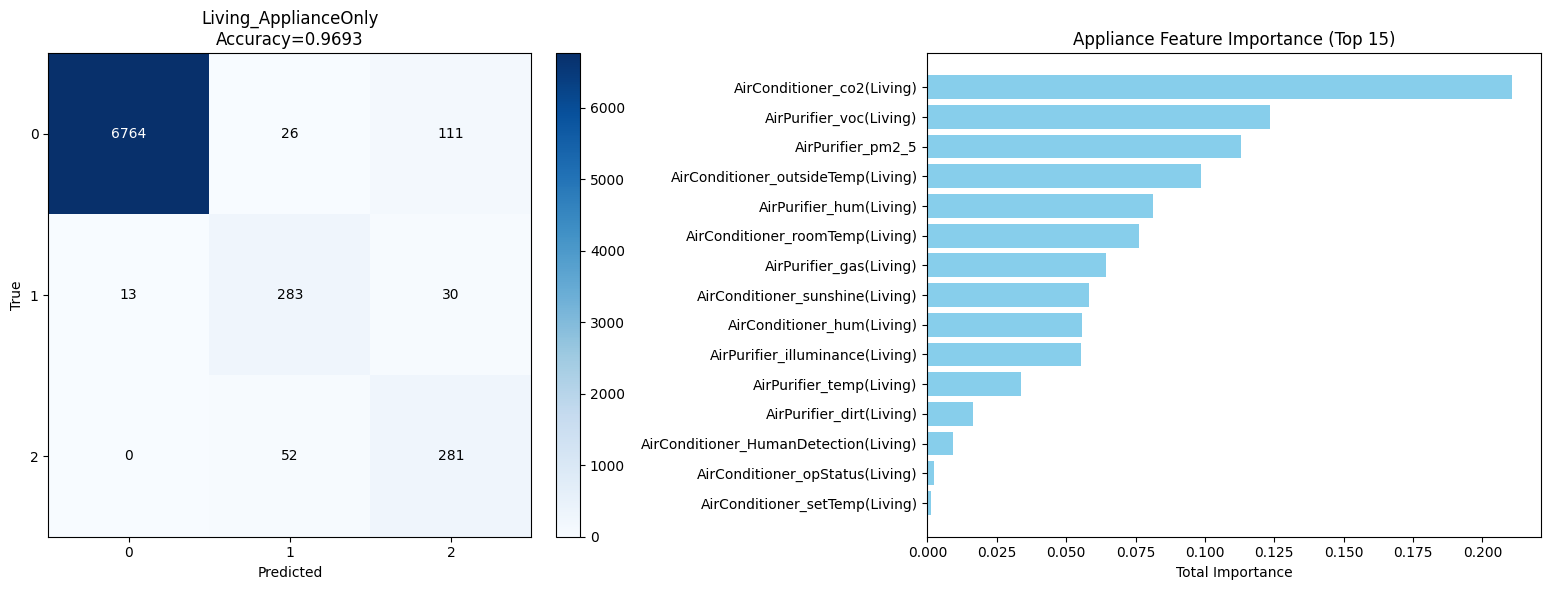


📥 Loading Japanese data from: 和室.csv ...
Resampling to 1min...
Using Appliance Columns: 20 (Num: 19, Hum: 1)
  [Japanese] Train: 17527, Test: 7560

--- Result: Japanese (Appliance Only) ---
              precision    recall  f1-score   support

           0      0.999     0.988     0.994      7121
           1      0.660     0.991     0.792       212
           2      0.990     0.863     0.922       227

    accuracy                          0.985      7560
   macro avg      0.883     0.947     0.903      7560
weighted avg      0.989     0.985     0.986      7560



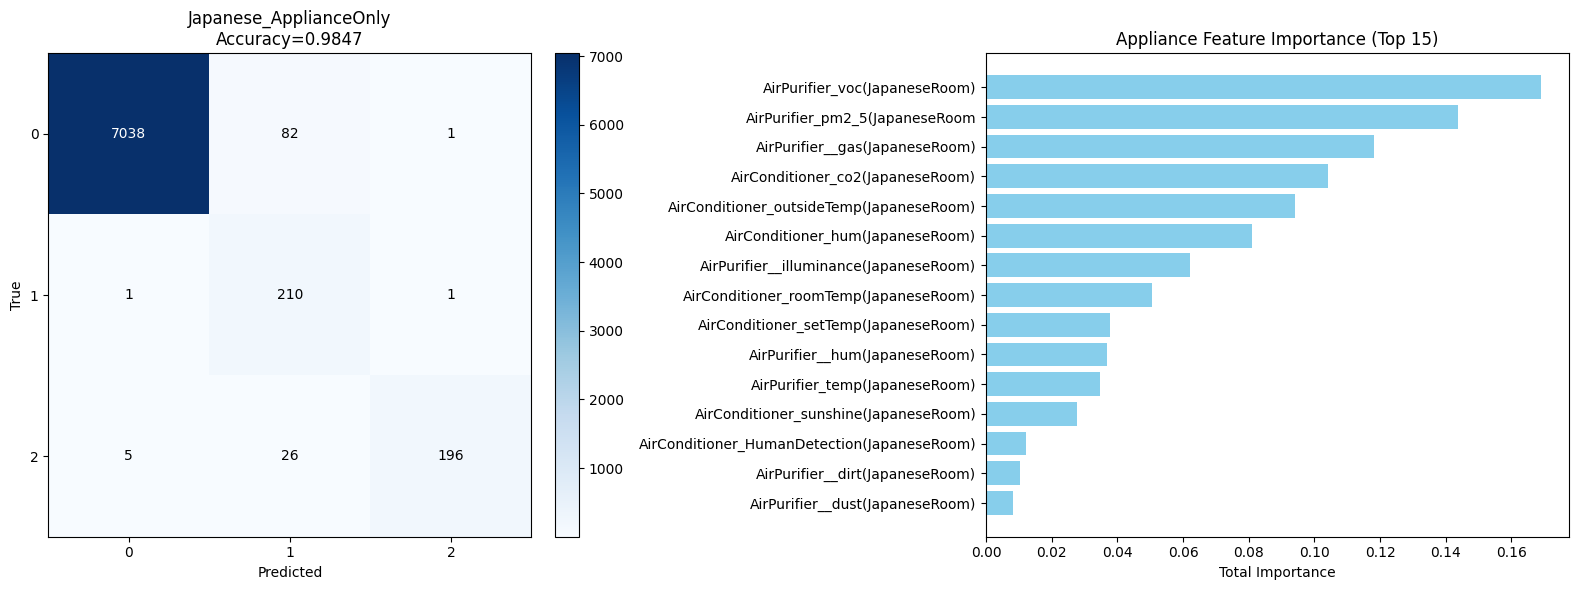


✅ Done.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =========================
# Config
# =========================
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

WINS = [5, 10, 15, 20, 25, 30, 60]
TOPK_IMPORTANCE = 15
SEED = 42

BLOCK_MINUTES = 30
TEST_RATIO = 0.30
THRESHOLD_OCCUPIED = 0.30

LABEL_COLS = [
    "Label_Living_Action",
    "Label_Living_Count",
    "Label_Japanese_Count",
    "Label_Japanese_Action",
    "Label_Total_People"
]

# =========================
# Utilities
# =========================
def fix_timestamp_robust(df: pd.DataFrame, col: str) -> pd.Series:
    s = df[col].astype(str)
    if s.iloc[0].startswith("20") and "-" in s.iloc[0]:
        return pd.to_datetime(s, errors="coerce")

    try:
        temp_dates = pd.to_datetime(s, format='%M:%S.%f', errors='coerce')
    except:
        temp_dates = pd.to_datetime(s, errors='coerce')

    if temp_dates.isna().mean() > 0.5:
         temp_dates = pd.to_datetime(s, errors='coerce')

    diff = temp_dates.diff()
    wrap_indices = diff < pd.Timedelta(minutes=-30)
    hours_to_add = wrap_indices.cumsum()
    fixed_dates = temp_dates + pd.to_timedelta(hours_to_add, unit='h')
    return fixed_dates

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]
    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())

    if not out: return pd.DataFrame()
    dfr = pd.concat(out, axis=1).sort_index()
    return safe_ffill(dfr).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

def aggregate_importances(feature_names, importances):
    base_feats = {}
    pattern = r'(_(mean|std|slope|sum)_\d+|_diff)$'
    for name, imp in zip(feature_names, importances):
        base_name = re.sub(pattern, '', name)
        if base_name in base_feats:
            base_feats[base_name] += imp
        else:
            base_feats[base_name] = imp
    return pd.Series(base_feats).sort_values(ascending=False)

def plot_cm_and_importance(title, y_true, y_pred, labels, feature_names, importances, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    fig = plt.figure(figsize=(16, 6))

    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Blues")
    ax1.set_title(f"{title}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(labels); ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = "white" if cm[i, j] > cm.max()/2 else "black"
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color=text_color)

    ax2 = plt.subplot(1, 2, 2)
    if importances is not None:
        agg_imp = aggregate_importances(feature_names, importances)
        top = agg_imp.head(topk)[::-1]
        ax2.barh(top.index, top.values, color="skyblue")
        ax2.set_title(f"Appliance Feature Importance (Top {topk})")
        ax2.set_xlabel("Total Importance")

    plt.tight_layout()
    plt.show()

# =========================
# Feature Engineering
# =========================
def build_numeric_features_multiwin(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns: continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)
        feats[c] = s
        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff"] = d1
        for w in wins:
            feats[f"{c}_mean_{w}"] = s.rolling(w).mean().fillna(0.0)
            feats[f"{c}_std_{w}"]  = s.rolling(w).std().fillna(0.0)
            # 傾き (簡易的に (Current - Old)/Window とする)
            feats[f"{c}_slope_{w}"] = (s - s.shift(w)).fillna(0.0) / w
    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X.loc[:, ~X.columns.duplicated()]

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns: continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}"] = s.rolling(w).sum().fillna(0.0)
    X = pd.DataFrame(feats, index=df.index)
    return X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# =========================
# Model & Prediction
# =========================
def rf_model():
    return RandomForestClassifier(
        n_estimators=300,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=4,
        max_depth=20
    )

def predict_with_threshold(model, X, threshold=0.3):
    probs = model.predict_proba(X)
    preds = np.argmax(probs, axis=1)
    for i in range(len(preds)):
        if preds[i] == 0:
            p_1 = probs[i][1] if probs.shape[1] > 1 else 0
            p_2 = probs[i][2] if probs.shape[1] > 2 else 0
            if p_1 >= threshold or p_2 >= threshold:
                preds[i] = 1 if p_1 >= p_2 else 2
    return preds

def run_appliance_only_analysis(filename: str, room: str, target_col: str):
    print(f"\n📥 Loading {room} data from: {filename} ...")
    try:
        df0 = pd.read_csv(filename, low_memory=False)
    except UnicodeDecodeError:
        df0 = pd.read_csv(filename, low_memory=False, encoding='cp932')

    if TIME_COL not in df0.columns:
        print(f"Error: {TIME_COL} not found.")
        return

    df0[TIME_COL] = fix_timestamp_robust(df0, TIME_COL)
    df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)
    df0 = safe_ffill(df0).fillna(0.0)

    print("Resampling to 1min...")
    df = resample_1min(df0, RESAMPLE_RULE)

    y = pd.to_numeric(df[target_col], errors="coerce").fillna(0).astype(int)
    y = y.apply(lambda x: x if x in [0, 1, 2] else 0)

    # === 家電のみのフィルタリング ===
    # キーワード: "AirPurifier" または "AirConditioner" を含む列のみ使用
    # 他のセンサー(M5Stack, PIRなど)は除外されます
    all_cols = [c for c in df.columns if c not in LABEL_COLS]
    appliance_cols = [c for c in all_cols if "AirPurifier" in c or "AirConditioner" in c]

    # センサーの種類別にリスト作成
    hum_cols = [c for c in appliance_cols if "human" in c.lower()] # 家電内蔵の人感センサーなど
    num_cols = [c for c in appliance_cols if c not in hum_cols]

    print(f"Using Appliance Columns: {len(appliance_cols)} (Num: {len(num_cols)}, Hum: {len(hum_cols)})")

    # 特徴量作成
    X_num = build_numeric_features_multiwin(df, num_cols, WINS)
    X_hum = build_human_features(df, hum_cols, WINS)
    X = pd.concat([X_num, X_hum], axis=1).fillna(0.0)

    # Split
    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_te, y_te = X.iloc[te_idx], y.iloc[te_idx]

    print(f"  [{room}] Train: {len(X_tr)}, Test: {len(X_te)}")

    model = rf_model()
    model.fit(X_tr, y_tr)

    pred = predict_with_threshold(model, X_te, threshold=THRESHOLD_OCCUPIED)

    print(f"\n--- Result: {room} (Appliance Only) ---")
    print(classification_report(y_te, pred, digits=3, zero_division=0))

    plot_cm_and_importance(
        f"{room}_ApplianceOnly",
        y_te, pred, [0, 1, 2],
        X.columns, model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

# =========================
# Main Execution
# =========================
run_appliance_only_analysis("リビング.csv", "Living", "Label_Living_Count")
run_appliance_only_analysis("和室.csv", "Japanese", "Label_Japanese_Count")
print("\n✅ Done.")


📥 Loading Living data from: リビング.csv ...
Resampling to 1min...
Using Appliance Columns: 18 (Num: 17, Hum: 1)
  [Living] Train: 17591, Test: 7560

--- Result: Living (Appliance Only) ---
              precision    recall  f1-score   support

           0      0.997     0.979     0.988      6901
           1      0.785     0.874     0.827       326
           2      0.671     0.844     0.747       333

    accuracy                          0.969      7560
   macro avg      0.818     0.899     0.854      7560
weighted avg      0.974     0.969     0.971      7560



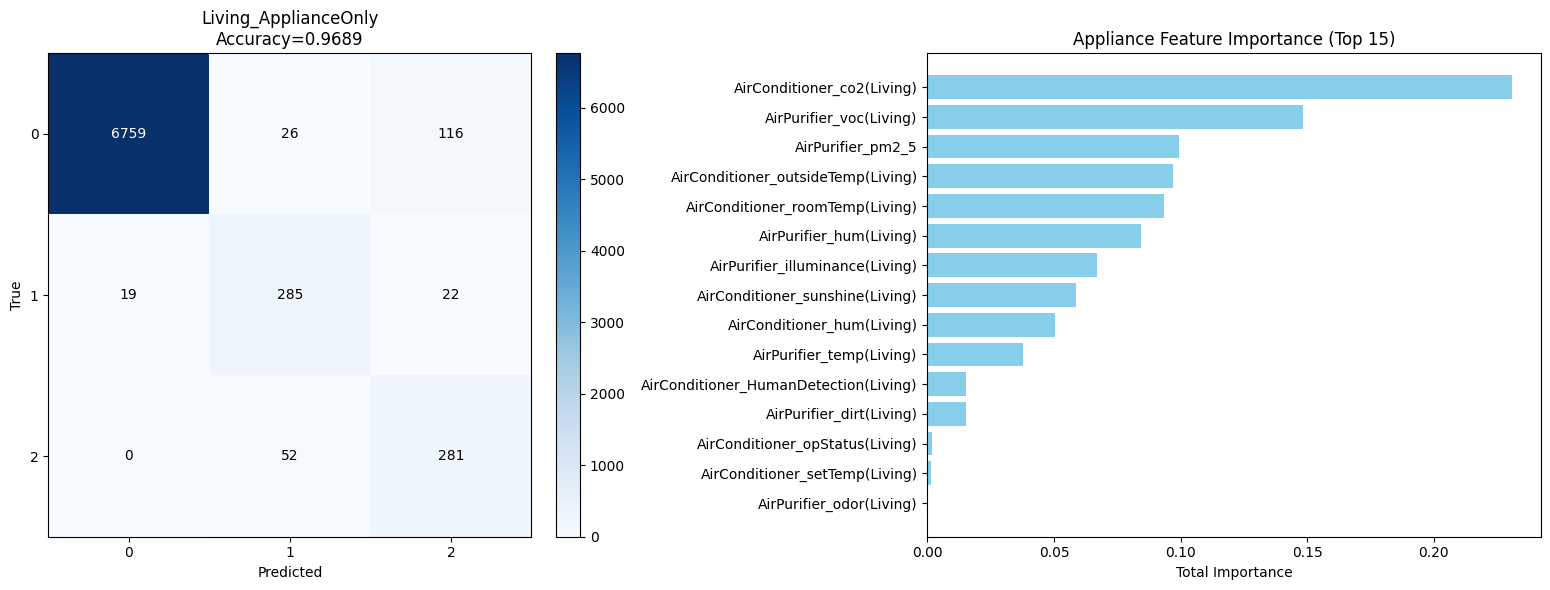


📥 Loading Japanese data from: 和室.csv ...
Resampling to 1min...
Using Appliance Columns: 19 (Num: 18, Hum: 1)
  [Japanese] Train: 17527, Test: 7560

--- Result: Japanese (Appliance Only) ---
              precision    recall  f1-score   support

           0      0.999     0.983     0.991      7121
           1      0.616     0.991     0.759       212
           2      0.943     0.881     0.911       227

    accuracy                          0.980      7560
   macro avg      0.853     0.952     0.887      7560
weighted avg      0.987     0.980     0.982      7560



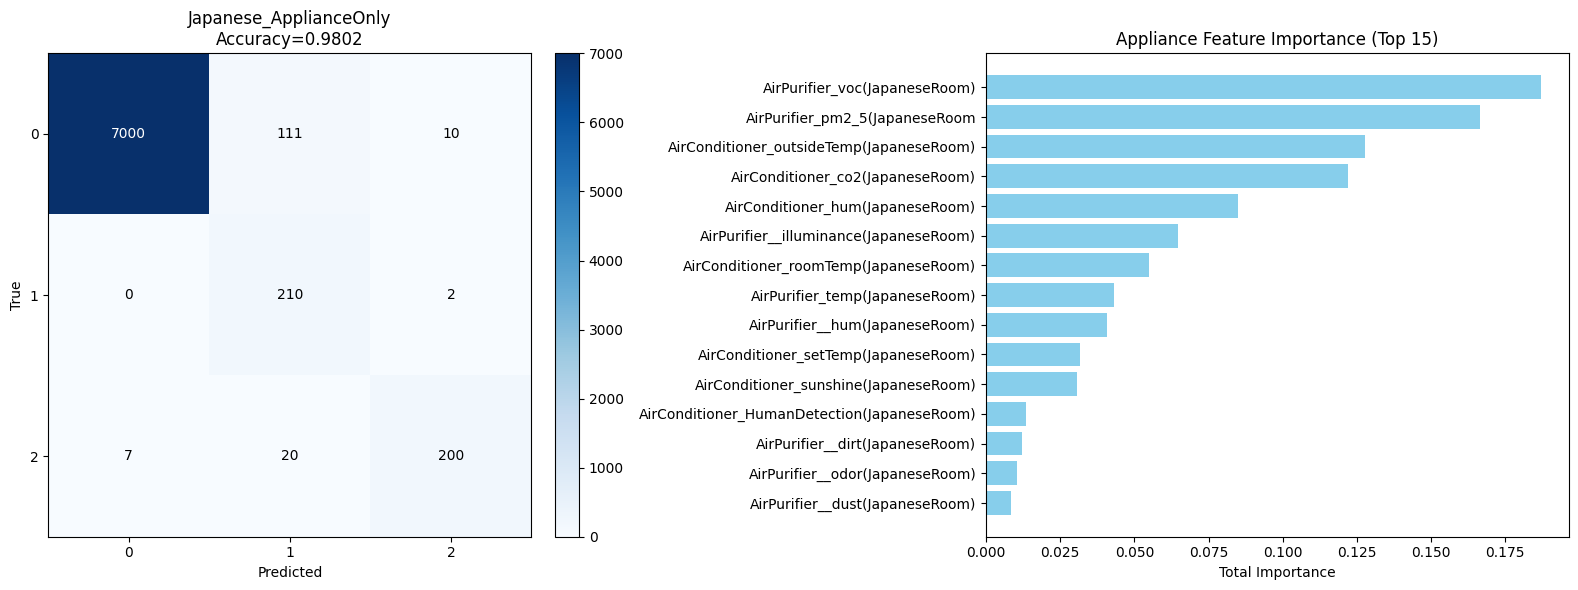


✅ Done.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =========================
# Config
# =========================
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

WINS = [5, 10, 15, 20, 25, 30, 60]
TOPK_IMPORTANCE = 15
SEED = 42

BLOCK_MINUTES = 30
TEST_RATIO = 0.30
THRESHOLD_OCCUPIED = 0.30

LABEL_COLS = [
    "Label_Living_Action",
    "Label_Living_Count",
    "Label_Japanese_Count",
    "Label_Japanese_Action",
    "Label_Total_People"
]

# =========================
# Utilities
# =========================
def fix_timestamp_robust(df: pd.DataFrame, col: str) -> pd.Series:
    s = df[col].astype(str)
    if s.iloc[0].startswith("20") and "-" in s.iloc[0]:
        return pd.to_datetime(s, errors="coerce")

    try:
        temp_dates = pd.to_datetime(s, format='%M:%S.%f', errors='coerce')
    except:
        temp_dates = pd.to_datetime(s, errors='coerce')

    if temp_dates.isna().mean() > 0.5:
         temp_dates = pd.to_datetime(s, errors='coerce')

    diff = temp_dates.diff()
    wrap_indices = diff < pd.Timedelta(minutes=-30)
    hours_to_add = wrap_indices.cumsum()
    fixed_dates = temp_dates + pd.to_timedelta(hours_to_add, unit='h')
    return fixed_dates

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]
    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())

    if not out: return pd.DataFrame()
    dfr = pd.concat(out, axis=1).sort_index()
    return safe_ffill(dfr).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

def aggregate_importances(feature_names, importances):
    base_feats = {}
    pattern = r'(_(mean|std|slope|sum)_\d+|_diff)$'
    for name, imp in zip(feature_names, importances):
        base_name = re.sub(pattern, '', name)
        if base_name in base_feats:
            base_feats[base_name] += imp
        else:
            base_feats[base_name] = imp
    return pd.Series(base_feats).sort_values(ascending=False)

def plot_cm_and_importance(title, y_true, y_pred, labels, feature_names, importances, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    fig = plt.figure(figsize=(16, 6))

    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Blues")
    ax1.set_title(f"{title}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(labels); ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = "white" if cm[i, j] > cm.max()/2 else "black"
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color=text_color)

    ax2 = plt.subplot(1, 2, 2)
    if importances is not None:
        agg_imp = aggregate_importances(feature_names, importances)
        top = agg_imp.head(topk)[::-1]
        ax2.barh(top.index, top.values, color="skyblue")
        ax2.set_title(f"Appliance Feature Importance (Top {topk})")
        ax2.set_xlabel("Total Importance")

    plt.tight_layout()
    plt.show()

# =========================
# Feature Engineering
# =========================
def build_numeric_features_multiwin(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns: continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)
        feats[c] = s
        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff"] = d1
        for w in wins:
            feats[f"{c}_mean_{w}"] = s.rolling(w).mean().fillna(0.0)
            feats[f"{c}_std_{w}"]  = s.rolling(w).std().fillna(0.0)
            # 傾き (簡易的に (Current - Old)/Window とする)
            feats[f"{c}_slope_{w}"] = (s - s.shift(w)).fillna(0.0) / w
    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X.loc[:, ~X.columns.duplicated()]

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns: continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}"] = s.rolling(w).sum().fillna(0.0)
    X = pd.DataFrame(feats, index=df.index)
    return X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# =========================
# Model & Prediction
# =========================
def rf_model():
    return RandomForestClassifier(
        n_estimators=300,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=4,
        max_depth=20
    )

def predict_with_threshold(model, X, threshold=0.3):
    probs = model.predict_proba(X)
    preds = np.argmax(probs, axis=1)
    for i in range(len(preds)):
        if preds[i] == 0:
            p_1 = probs[i][1] if probs.shape[1] > 1 else 0
            p_2 = probs[i][2] if probs.shape[1] > 2 else 0
            if p_1 >= threshold or p_2 >= threshold:
                preds[i] = 1 if p_1 >= p_2 else 2
    return preds

def run_appliance_only_analysis(filename: str, room: str, target_col: str):
    print(f"\n📥 Loading {room} data from: {filename} ...")
    try:
        df0 = pd.read_csv(filename, low_memory=False)
    except UnicodeDecodeError:
        df0 = pd.read_csv(filename, low_memory=False, encoding='cp932')

    if TIME_COL not in df0.columns:
        print(f"Error: {TIME_COL} not found.")
        return

    df0[TIME_COL] = fix_timestamp_robust(df0, TIME_COL)
    df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)
    df0 = safe_ffill(df0).fillna(0.0)

    print("Resampling to 1min...")
    df = resample_1min(df0, RESAMPLE_RULE)

    y = pd.to_numeric(df[target_col], errors="coerce").fillna(0).astype(int)
    y = y.apply(lambda x: x if x in [0, 1, 2] else 0)

    # === 家電のみのフィルタリング ===
    # キーワード: "AirPurifier" または "AirConditioner" を含む列のみ使用
    # 他のセンサー(M5Stack, PIRなど)は除外されます
    all_cols = [c for c in df.columns if c not in LABEL_COLS]
    appliance_cols = [c for c in all_cols if "AirPurifier" in c or "AirConditioner" in c]

    # センサーの種類別にリスト作成
    hum_cols = [c for c in appliance_cols if "human" in c.lower()] # 家電内蔵の人感センサーなど
    num_cols = [c for c in appliance_cols if c not in hum_cols]

    print(f"Using Appliance Columns: {len(appliance_cols)} (Num: {len(num_cols)}, Hum: {len(hum_cols)})")

    # 特徴量作成
    X_num = build_numeric_features_multiwin(df, num_cols, WINS)
    X_hum = build_human_features(df, hum_cols, WINS)
    X = pd.concat([X_num, X_hum], axis=1).fillna(0.0)

    # Split
    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_te, y_te = X.iloc[te_idx], y.iloc[te_idx]

    print(f"  [{room}] Train: {len(X_tr)}, Test: {len(X_te)}")

    model = rf_model()
    model.fit(X_tr, y_tr)

    pred = predict_with_threshold(model, X_te, threshold=THRESHOLD_OCCUPIED)

    print(f"\n--- Result: {room} (Appliance Only) ---")
    print(classification_report(y_te, pred, digits=3, zero_division=0))

    plot_cm_and_importance(
        f"{room}_ApplianceOnly",
        y_te, pred, [0, 1, 2],
        X.columns, model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

# =========================
# Main Execution
# =========================
run_appliance_only_analysis("リビング.csv", "Living", "Label_Living_Count")
run_appliance_only_analysis("和室.csv", "Japanese", "Label_Japanese_Count")
print("\n✅ Done.")


📥 Loading Living (All) data from: /content/リビング.csv ...
  Features -> Numeric: 25, Event/Human: 6
  Train: 17591, Test: 7560
  Class Balance (Test): {0: 6901, 1: 659}

--- Result: Living [All] (Binary: 0 vs 1+) ---
              precision    recall  f1-score   support

       Empty      0.997     0.995     0.996      6901
    Occupied      0.947     0.973     0.960       659

    accuracy                          0.993      7560
   macro avg      0.972     0.984     0.978      7560
weighted avg      0.993     0.993     0.993      7560



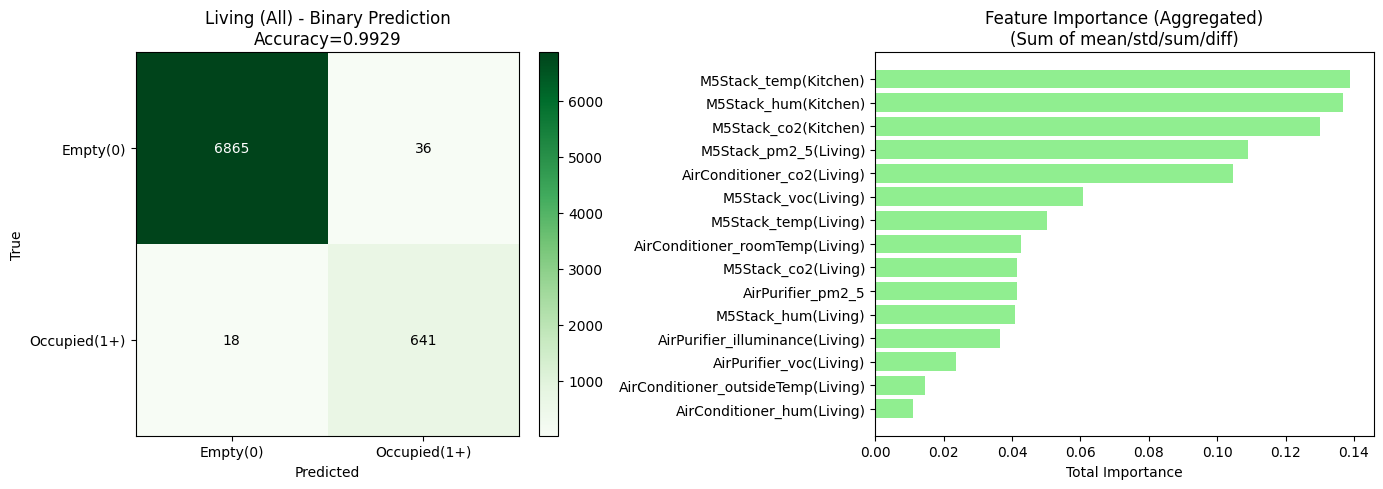


📥 Loading Living (Appliance) data from: /content/リビング.csv ...
  Features -> Numeric: 17, Event/Human: 1
  Train: 17591, Test: 7560
  Class Balance (Test): {0: 6901, 1: 659}

--- Result: Living [Appliance] (Binary: 0 vs 1+) ---
              precision    recall  f1-score   support

       Empty      0.997     0.993     0.995      6901
    Occupied      0.933     0.970     0.951       659

    accuracy                          0.991      7560
   macro avg      0.965     0.981     0.973      7560
weighted avg      0.991     0.991     0.991      7560



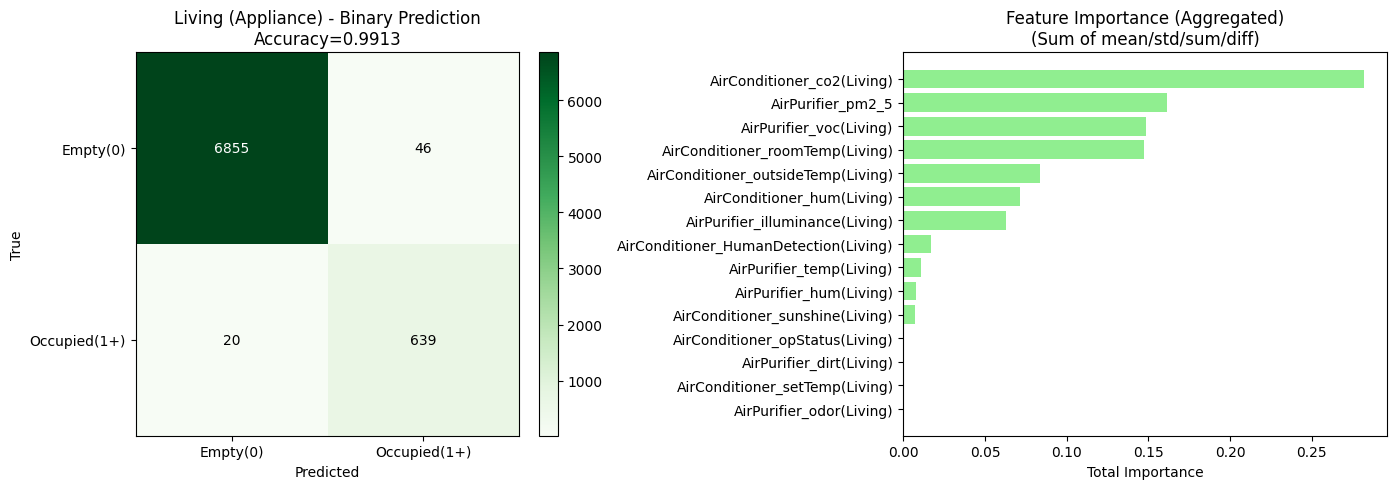


📥 Loading Japanese (All) data from: /content/和室.csv ...
  Features -> Numeric: 21, Event/Human: 3
  Train: 17527, Test: 7560
  Class Balance (Test): {0: 7121, 1: 439}

--- Result: Japanese [All] (Binary: 0 vs 1+) ---
              precision    recall  f1-score   support

       Empty      0.996     0.996     0.996      7121
    Occupied      0.930     0.936     0.933       439

    accuracy                          0.992      7560
   macro avg      0.963     0.966     0.964      7560
weighted avg      0.992     0.992     0.992      7560



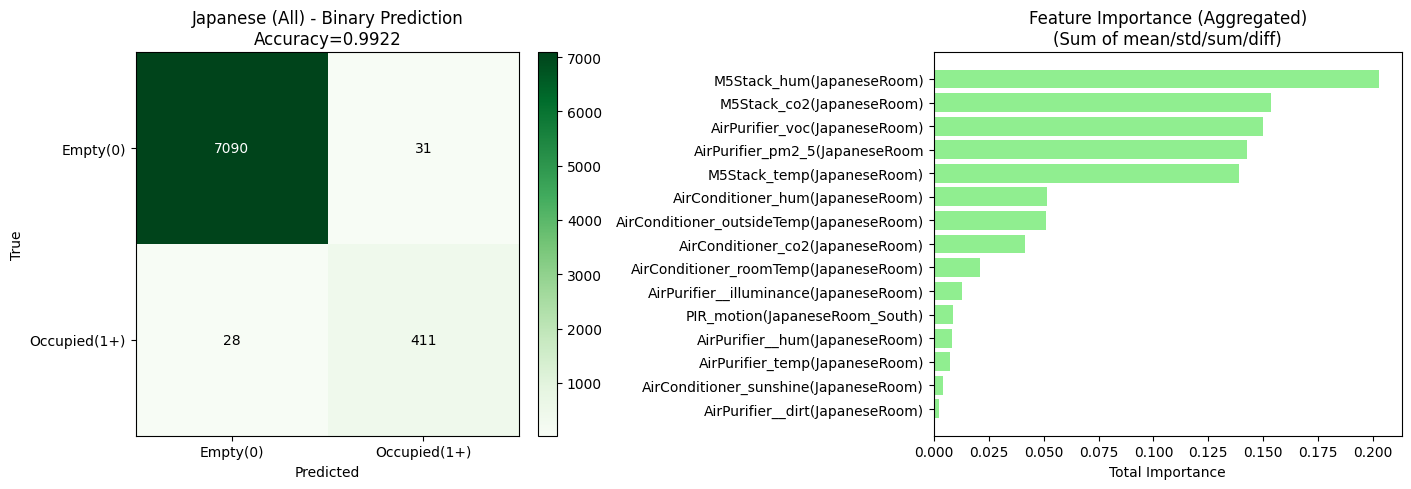


📥 Loading Japanese (Appliance) data from: /content/和室.csv ...
  Features -> Numeric: 18, Event/Human: 1
  Train: 17527, Test: 7560
  Class Balance (Test): {0: 7121, 1: 439}

--- Result: Japanese [Appliance] (Binary: 0 vs 1+) ---
              precision    recall  f1-score   support

       Empty      0.996     0.995     0.995      7121
    Occupied      0.913     0.927     0.920       439

    accuracy                          0.991      7560
   macro avg      0.954     0.961     0.957      7560
weighted avg      0.991     0.991     0.991      7560



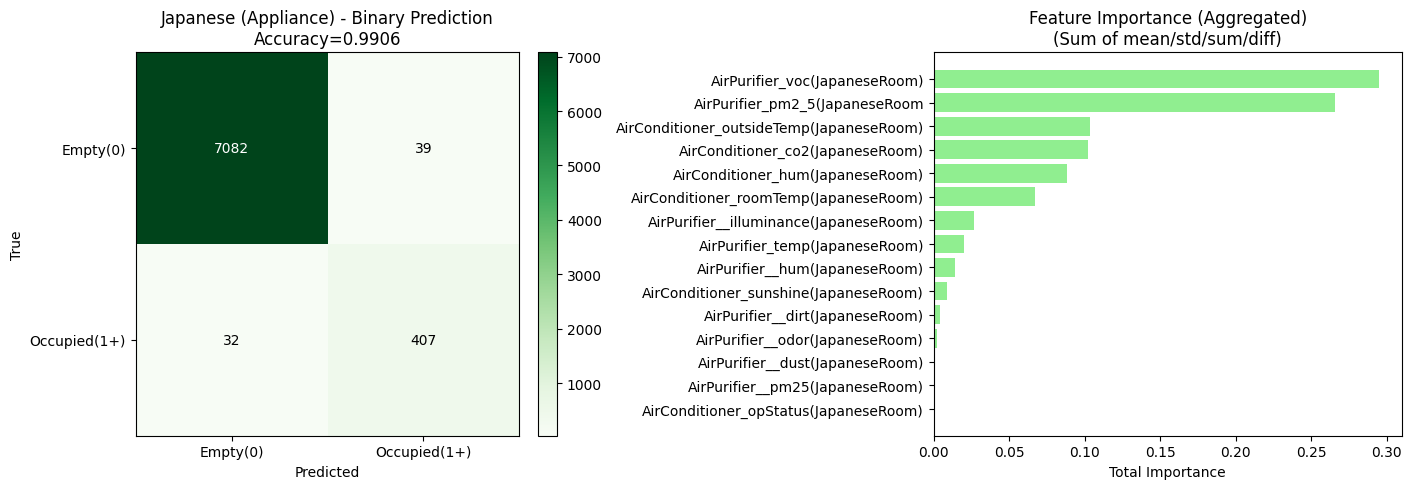


✅ Done.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =========================
# Config
# =========================
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

# 窓幅の定義 (分)
# PIRなどの累積にはこれら期間の合計値(Sum)が使われます
WINS = [5, 10, 15, 20, 25, 30, 60]

TOPK_IMPORTANCE = 15
SEED = 42
BLOCK_MINUTES = 30
TEST_RATIO = 0.30

# 分析設定
LABEL_COLS = [
    "Label_Living_Action",
    "Label_Living_Count",
    "Label_Japanese_Count",
    "Label_Japanese_Action",
    "Label_Total_People"
]

# =========================
# Utilities
# =========================
def fix_timestamp_robust(df: pd.DataFrame, col: str) -> pd.Series:
    s = df[col].astype(str)
    if s.iloc[0].startswith("20") and "-" in s.iloc[0]:
        return pd.to_datetime(s, errors="coerce")
    try:
        temp_dates = pd.to_datetime(s, format='%M:%S.%f', errors='coerce')
    except:
        temp_dates = pd.to_datetime(s, errors='coerce')
    if temp_dates.isna().mean() > 0.5:
         temp_dates = pd.to_datetime(s, errors='coerce')
    diff = temp_dates.diff()
    wrap_indices = diff < pd.Timedelta(minutes=-30)
    hours_to_add = wrap_indices.cumsum()
    return temp_dates + pd.to_timedelta(hours_to_add, unit='h')

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]
    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())
    if not out: return pd.DataFrame()
    dfr = pd.concat(out, axis=1).sort_index()
    return safe_ffill(dfr).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

# ---------------------------------------------------------
# Feature Importance Aggregation
# ---------------------------------------------------------
def aggregate_importances(feature_names, importances):
    base_names = []
    # 末尾の _sum_5, _mean_10, _diff などを除去
    pattern = re.compile(r'(_diff|_mean_\d+|_std_\d+|_slope_\d+|_sum_\d+)$')

    for name in feature_names:
        base = pattern.sub('', name)
        base_names.append(base)

    df_imp = pd.DataFrame({'feature': base_names, 'importance': importances})
    grouped = df_imp.groupby('feature')['importance'].sum().sort_values(ascending=False)
    return grouped

def plot_cm_and_importance_aggregated(title, y_true, y_pred, labels, feature_names, importances, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Aggregation
    agg_imp = aggregate_importances(feature_names, importances)

    fig = plt.figure(figsize=(14, 5))

    # Confusion Matrix
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Blues") # 2値分類なので緑系に変更
    ax1.set_title(f"{title}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(["Empty(0)", "Occupied(1+)"]); ax1.set_yticklabels(["Empty(0)", "Occupied(1+)"])
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = "white" if cm[i, j] > cm.max()/2 else "black"
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color=text_color)

    # Aggregated Importance Plot
    ax2 = plt.subplot(1, 2, 2)
    top = agg_imp.head(topk)[::-1]
    ax2.barh(top.index, top.values, color="skyblue")
    ax2.set_title(f"Feature Importance (Aggregated)\n(Sum of mean/std/sum/diff)")
    ax2.set_xlabel("Total Importance")

    plt.tight_layout()
    plt.show()

# =========================
# Feature Engineering
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3: return pd.Series(0.0, index=y.index)
    return (y - y.shift(w)).fillna(0.0) / w

def build_numeric_features(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns: continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)
        feats[c] = s
        feats[f"{c}_diff"] = s.diff().fillna(0.0)
        for w in wins:
            feats[f"{c}_mean_{w}"] = s.rolling(w).mean().fillna(0.0)
            feats[f"{c}_std_{w}"]  = s.rolling(w).std().fillna(0.0)
            feats[f"{c}_slope_{w}"] = _rolling_linreg_slope(s, w)
    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X.loc[:, ~X.columns.duplicated()]

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    """
    PIRや人検知フラグ用。
    累積和(Sum)をとることで、「過去N分間に反応があったか」を捉える。
    """
    feats = {}
    for c in human_cols:
        if c not in df.columns: continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s # 生の値
        for w in wins:
            # 重要: ここでSumをとることで累積反応を見る
            feats[f"{c}_sum_{w}"] = s.rolling(w).sum().fillna(0.0)
    X = pd.DataFrame(feats, index=df.index)
    return X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# =========================
# Main Logic
# =========================
def run_binary_analysis(filename: str, room: str, target_col: str, mode: str = "All"):
    """
    mode: "All" (全センサー) or "Appliance" (家電のみ)
    """
    print(f"\n📥 Loading {room} ({mode}) data from: {filename} ...")
    try:
        df0 = pd.read_csv(filename, low_memory=False)
    except UnicodeDecodeError:
        df0 = pd.read_csv(filename, low_memory=False, encoding='cp932')

    if TIME_COL not in df0.columns: return
    if target_col not in df0.columns: return

    # Timestamp
    df0[TIME_COL] = fix_timestamp_robust(df0, TIME_COL)
    df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)
    df0 = safe_ffill(df0).fillna(0.0)

    # Resample
    df = resample_1min(df0, RESAMPLE_RULE)

    # ----------------------------------------------------
    # Label Binarization: 0 vs 1+
    # ----------------------------------------------------
    y_raw = pd.to_numeric(df[target_col], errors="coerce").fillna(0).astype(int)
    # 1以上なら1、0なら0に変換
    y = (y_raw > 0).astype(int)

    # ----------------------------------------------------
    # Feature Selection (Mode Switch)
    # ----------------------------------------------------
    all_cols = [c for c in df.columns if c not in LABEL_COLS]

    if mode == "Appliance":
        # 家電 (AirPurifier, AirConditioner) のみ抽出
        # ※ 家電内蔵の人感センサーも含める
        target_cols = [c for c in all_cols if "AirPurifier" in c or "AirConditioner" in c]
    else:
        # すべて
        target_cols = all_cols

    # 数値系とブール/イベント系(Human, PIR)に分離
    hum_cols = [c for c in target_cols if "human" in c.lower() or "pir" in c.lower() or "motion" in c.lower()]
    num_cols = [c for c in target_cols if c not in hum_cols]

    print(f"  Features -> Numeric: {len(num_cols)}, Event/Human: {len(hum_cols)}")

    # 特徴量作成
    X_num = build_numeric_features(df, num_cols, WINS)
    X_hum = build_human_features(df, hum_cols, WINS) # ここで累積(sum)が計算される
    X = pd.concat([X_num, X_hum], axis=1).fillna(0.0)

    # Split
    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))
    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_te, y_te = X.iloc[te_idx], y.iloc[te_idx]

    print(f"  Train: {len(X_tr)}, Test: {len(X_te)}")
    print(f"  Class Balance (Test): {y_te.value_counts().to_dict()}")

    # Model
    model = RandomForestClassifier(
        n_estimators=500,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=4,
    )
    model.fit(X_tr, y_tr)

    # Predict
    pred = model.predict(X_te)

    # Report
    print(f"\n--- Result: {room} [{mode}] (Binary: 0 vs 1+) ---")
    print(classification_report(y_te, pred, target_names=["Empty", "Occupied"], digits=3))

    # Plot
    plot_cm_and_importance_aggregated(
        f"{room} ({mode}) - Binary Prediction",
        y_te, pred, [0, 1],
        X.columns, model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

# =========================
# Execution
# =========================

# 1. Living Analysis
run_binary_analysis("/content/リビング.csv", "Living", "Label_Living_Count", mode="All")
run_binary_analysis("/content/リビング.csv", "Living", "Label_Living_Count", mode="Appliance")

# 2. Japanese Room Analysis
run_binary_analysis("/content/和室.csv", "Japanese", "Label_Japanese_Count", mode="All")
run_binary_analysis("/content/和室.csv", "Japanese", "Label_Japanese_Count", mode="Appliance")

print("\n✅ Done.")


📥 Loading Living (All) data from: /content/リビング.csv ...
  Features -> Numeric: 25, Event/Human: 6
  Train: 17591, Test: 7560

--- Result: Living [All] (LightGBM: 0/1/2) ---
              precision    recall  f1-score   support

           0      0.996     0.988     0.992      6901
           1      0.799     0.804     0.801       326
           2      0.736     0.853     0.790       333

    accuracy                          0.974      7560
   macro avg      0.844     0.882     0.861      7560
weighted avg      0.976     0.974     0.975      7560



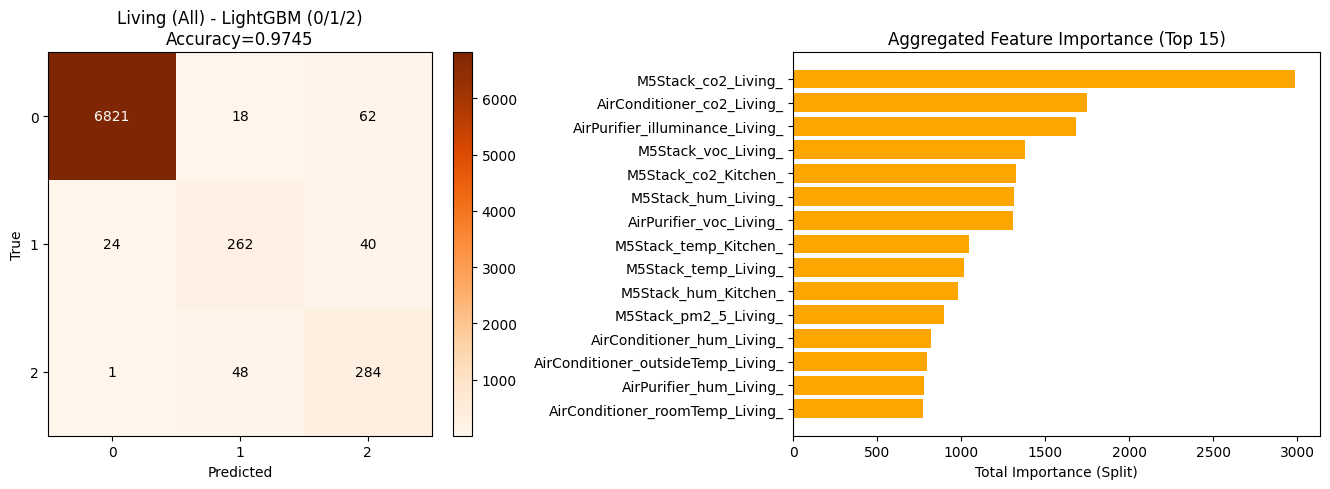


📥 Loading Living (Appliance) data from: /content/リビング.csv ...
  Features -> Numeric: 17, Event/Human: 1
  Train: 17591, Test: 7560

--- Result: Living [Appliance] (LightGBM: 0/1/2) ---
              precision    recall  f1-score   support

           0      0.996     0.989     0.992      6901
           1      0.788     0.868     0.826       326
           2      0.727     0.760     0.743       333

    accuracy                          0.974      7560
   macro avg      0.837     0.872     0.854      7560
weighted avg      0.975     0.974     0.974      7560



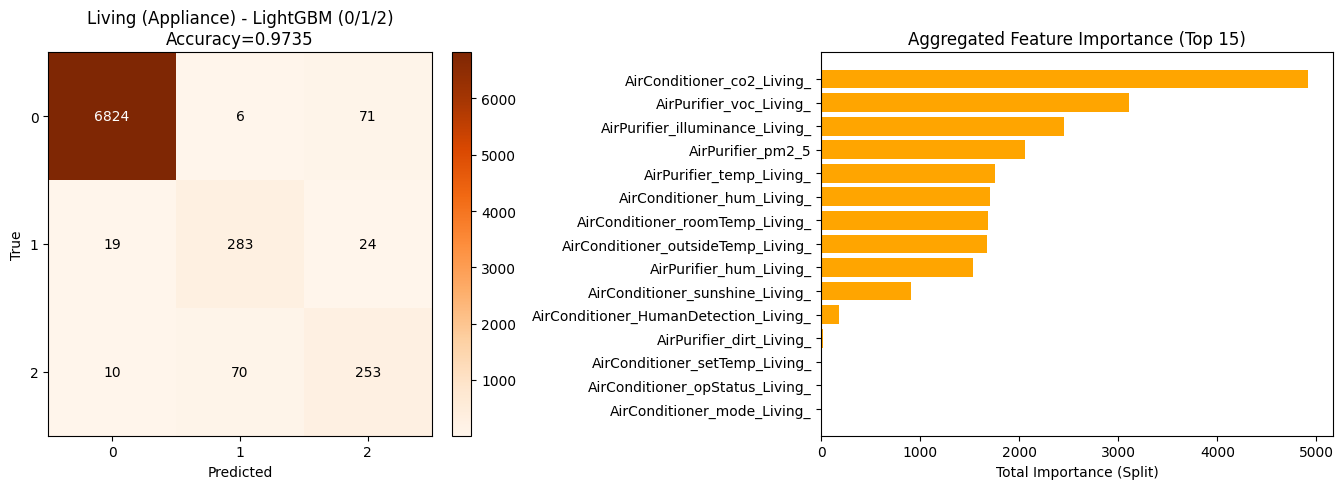


📥 Loading Japanese (All) data from: /content/和室.csv ...
  Features -> Numeric: 21, Event/Human: 3
  Train: 17527, Test: 7560

--- Result: Japanese [All] (LightGBM: 0/1/2) ---
              precision    recall  f1-score   support

           0      0.998     0.996     0.997      7121
           1      0.807     0.986     0.887       212
           2      1.000     0.837     0.911       227

    accuracy                          0.991      7560
   macro avg      0.935     0.940     0.932      7560
weighted avg      0.993     0.991     0.992      7560



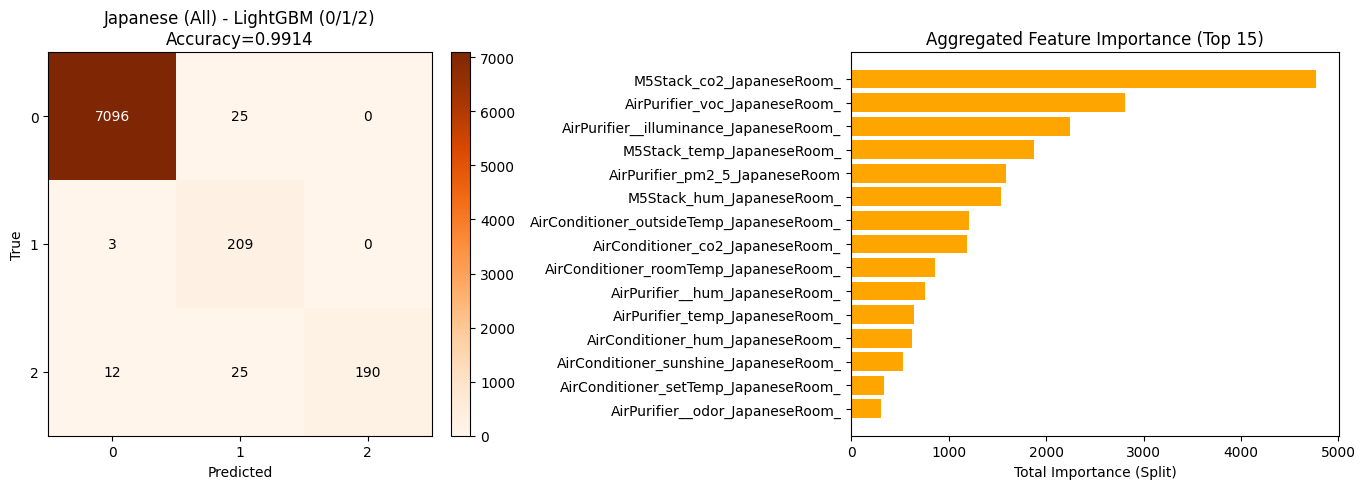


📥 Loading Japanese (Appliance) data from: /content/和室.csv ...
  Features -> Numeric: 18, Event/Human: 1
  Train: 17527, Test: 7560

--- Result: Japanese [Appliance] (LightGBM: 0/1/2) ---
              precision    recall  f1-score   support

           0      0.995     0.996     0.996      7121
           1      0.757     0.910     0.827       212
           2      0.940     0.753     0.836       227

    accuracy                          0.986      7560
   macro avg      0.897     0.886     0.886      7560
weighted avg      0.987     0.986     0.986      7560



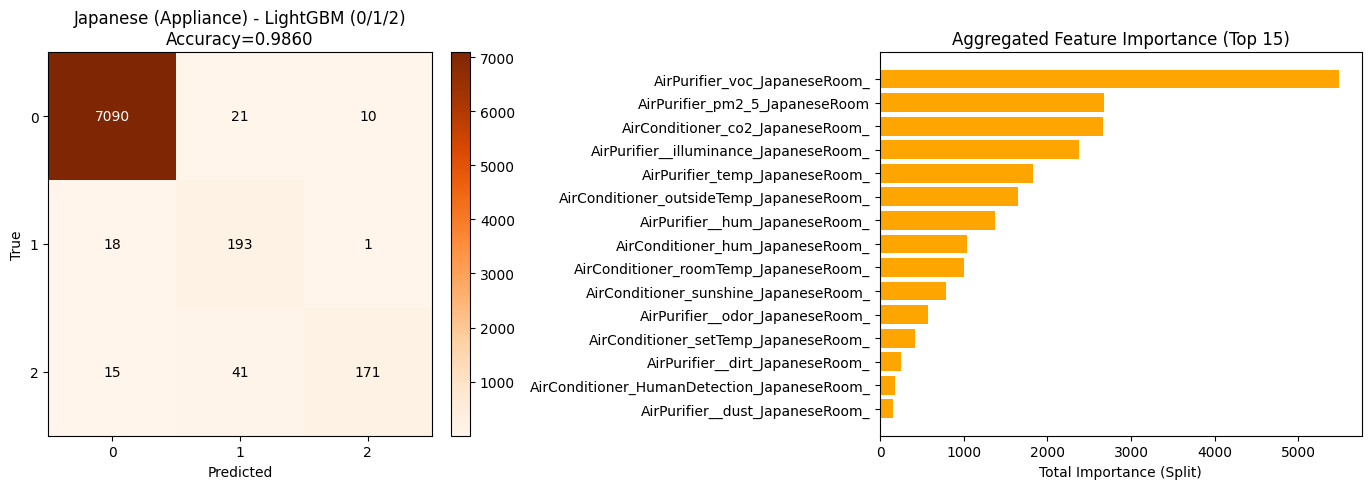


✅ Done.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import lightgbm as lgb

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =========================
# Config
# =========================
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

# 窓幅 (分) - 統計特徴量作成用
WINS = [5, 10, 15, 20, 25, 30, 60]

TOPK_IMPORTANCE = 15
SEED = 42
BLOCK_MINUTES = 30
TEST_RATIO = 0.30

# 除外するラベル列など
LABEL_COLS = [
    "Label_Living_Action",
    "Label_Living_Count",
    "Label_Japanese_Count",
    "Label_Japanese_Action",
    "Label_Total_People"
]

# =========================
# Utilities
# =========================
def fix_timestamp_robust(df: pd.DataFrame, col: str) -> pd.Series:
    s = df[col].astype(str)
    if s.iloc[0].startswith("20") and "-" in s.iloc[0]:
        return pd.to_datetime(s, errors="coerce")
    try:
        temp_dates = pd.to_datetime(s, format='%M:%S.%f', errors='coerce')
    except:
        temp_dates = pd.to_datetime(s, errors='coerce')
    if temp_dates.isna().mean() > 0.5:
         temp_dates = pd.to_datetime(s, errors='coerce')
    diff = temp_dates.diff()
    wrap_indices = diff < pd.Timedelta(minutes=-30)
    hours_to_add = wrap_indices.cumsum()
    return temp_dates + pd.to_timedelta(hours_to_add, unit='h')

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]
    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())
    if not out: return pd.DataFrame()
    dfr = pd.concat(out, axis=1).sort_index()
    return safe_ffill(dfr).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """LightGBM用にカラム名の特殊文字を除去する"""
    new_cols = []
    for c in df.columns:
        # JSON非互換文字やLightGBMが嫌う記号を置換
        c_clean = re.sub(r'[(),\[\]]', '_', c)
        new_cols.append(c_clean)
    df.columns = new_cols
    return df

# ---------------------------------------------------------
# Feature Importance Aggregation
# ---------------------------------------------------------
def aggregate_importances(feature_names, importances):
    base_names = []
    # 末尾の派生サフィックス(_mean_5, _std_10, _diffなど)を除去してベース名を取得
    # カラム名クリーニングで () が _ になっているので、そこも考慮
    pattern = re.compile(r'(_diff|_mean_\d+|_std_\d+|_slope_\d+|_sum_\d+)$')

    for name in feature_names:
        base = pattern.sub('', name)
        base_names.append(base)

    df_imp = pd.DataFrame({'feature': base_names, 'importance': importances})
    grouped = df_imp.groupby('feature')['importance'].sum().sort_values(ascending=False)
    return grouped

def plot_cm_and_importance_lgbm(title, y_true, y_pred, labels, feature_names, importances, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    fig = plt.figure(figsize=(14, 5))

    # 1. Confusion Matrix
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Oranges") # LightGBMっぽくオレンジ系で
    ax1.set_title(f"{title}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(labels); ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = "white" if cm[i, j] > cm.max()/2 else "black"
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color=text_color)

    # 2. Aggregated Feature Importance
    ax2 = plt.subplot(1, 2, 2)
    agg_imp = aggregate_importances(feature_names, importances)
    top = agg_imp.head(topk)[::-1]

    ax2.barh(top.index, top.values, color="orange")
    ax2.set_title(f"Aggregated Feature Importance (Top {topk})")
    ax2.set_xlabel("Total Importance (Split)")

    plt.tight_layout()
    plt.show()

# =========================
# Feature Engineering
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3: return pd.Series(0.0, index=y.index)
    return (y - y.shift(w)).fillna(0.0) / w

def build_numeric_features(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns: continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)
        feats[c] = s
        feats[f"{c}_diff"] = s.diff().fillna(0.0)
        for w in wins:
            feats[f"{c}_mean_{w}"] = s.rolling(w).mean().fillna(0.0)
            feats[f"{c}_std_{w}"]  = s.rolling(w).std().fillna(0.0)
            feats[f"{c}_slope_{w}"] = _rolling_linreg_slope(s, w)
    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X.loc[:, ~X.columns.duplicated()]

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns: continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}"] = s.rolling(w).sum().fillna(0.0)
    X = pd.DataFrame(feats, index=df.index)
    return X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# =========================
# Main Logic (LightGBM)
# =========================
def run_lgbm_analysis(filename: str, room: str, target_col: str, mode: str = "All"):
    """
    mode: "All" (全センサー) or "Appliance" (家電のみ)
    target: 0/1/2人 (Multiclass)
    """
    print(f"\n📥 Loading {room} ({mode}) data from: {filename} ...")
    try:
        df0 = pd.read_csv(filename, low_memory=False)
    except UnicodeDecodeError:
        df0 = pd.read_csv(filename, low_memory=False, encoding='cp932')

    if TIME_COL not in df0.columns: return
    if target_col not in df0.columns: return

    # Timestamp
    df0[TIME_COL] = fix_timestamp_robust(df0, TIME_COL)
    df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)
    df0 = safe_ffill(df0).fillna(0.0)

    # Resample
    df = resample_1min(df0, RESAMPLE_RULE)

    # Label (0, 1, 2)
    y = pd.to_numeric(df[target_col], errors="coerce").fillna(0).astype(int)
    y = y.apply(lambda x: x if x in [0, 1, 2] else 0) # 0,1,2以外は0に

    # Feature Selection
    all_cols = [c for c in df.columns if c not in LABEL_COLS]

    if mode == "Appliance":
        # 家電 (AirPurifier, AirConditioner) のみ
        # 家電内蔵の人感センサーも含む
        target_cols = [c for c in all_cols if "AirPurifier" in c or "AirConditioner" in c]
    else:
        # すべて
        target_cols = all_cols

    # 数値系とブール/イベント系に分離
    hum_cols = [c for c in target_cols if "human" in c.lower() or "pir" in c.lower() or "motion" in c.lower()]
    num_cols = [c for c in target_cols if c not in hum_cols]

    print(f"  Features -> Numeric: {len(num_cols)}, Event/Human: {len(hum_cols)}")

    # 特徴量作成
    X_num = build_numeric_features(df, num_cols, WINS)
    X_hum = build_human_features(df, hum_cols, WINS)
    X = pd.concat([X_num, X_hum], axis=1).fillna(0.0)

    # LightGBM用にカラム名をクリーニング
    X = clean_column_names(X)

    # Split
    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_te, y_te = X.iloc[te_idx], y.iloc[te_idx]

    print(f"  Train: {len(X_tr)}, Test: {len(X_te)}")

    # LightGBM Model
    # 多クラス分類設定
    model = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=3,
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        random_state=SEED,
        n_jobs=-1,
        class_weight='balanced',
        verbose=-1 # ログ抑制
    )

    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)

    # Report
    print(f"\n--- Result: {room} [{mode}] (LightGBM: 0/1/2) ---")
    print(classification_report(y_te, pred, digits=3, zero_division=0))

    # Plot
    plot_cm_and_importance_lgbm(
        f"{room} ({mode}) - LightGBM (0/1/2)",
        y_te, pred, [0, 1, 2],
        X.columns, model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

# =========================
# Execution
# =========================

# 1. Living Analysis
run_lgbm_analysis("/content/リビング.csv", "Living", "Label_Living_Count", mode="All")
run_lgbm_analysis("/content/リビング.csv", "Living", "Label_Living_Count", mode="Appliance")

# 2. Japanese Room Analysis
run_lgbm_analysis("/content/和室.csv", "Japanese", "Label_Japanese_Count", mode="All")
run_lgbm_analysis("/content/和室.csv", "Japanese", "Label_Japanese_Count", mode="Appliance")

print("\n✅ Done.")


📥 Loading Living (All) data from: /content/リビング.csv ...
  Features -> Numeric: 25, Event/Human: 6
  Train: 17591, Test: 7560

--- Result: Living [All] (XGBoost: 0/1/2) ---
              precision    recall  f1-score   support

           0      0.997     0.994     0.995      6901
           1      0.797     0.914     0.851       326
           2      0.842     0.787     0.814       333

    accuracy                          0.981      7560
   macro avg      0.879     0.898     0.887      7560
weighted avg      0.982     0.981     0.981      7560



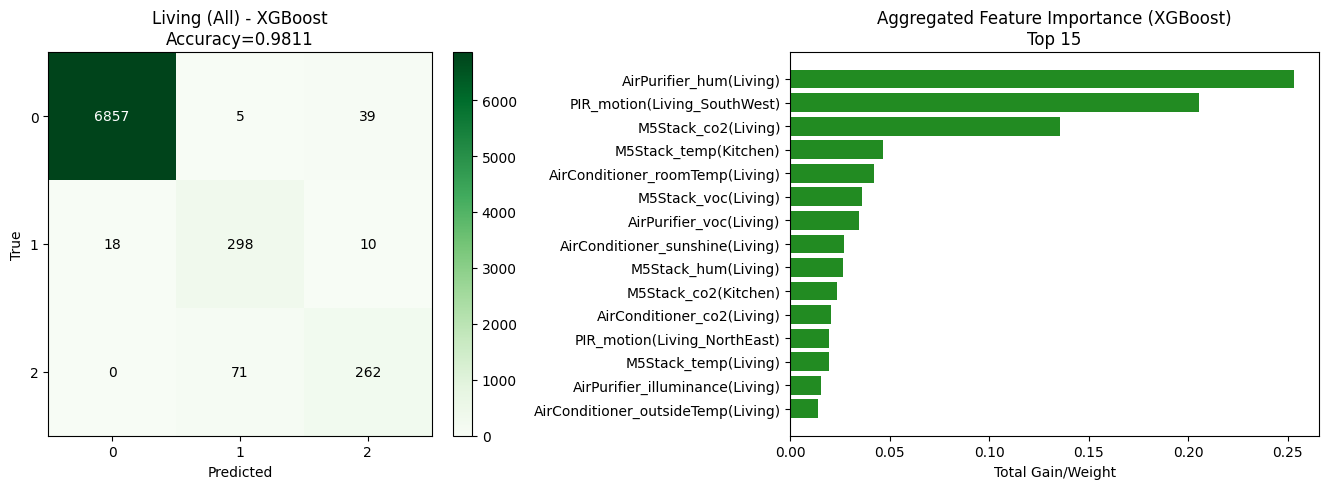


📥 Loading Living (Appliance) data from: /content/リビング.csv ...
  Features -> Numeric: 17, Event/Human: 1
  Train: 17591, Test: 7560

--- Result: Living [Appliance] (XGBoost: 0/1/2) ---
              precision    recall  f1-score   support

           0      0.997     0.992     0.994      6901
           1      0.814     0.923     0.865       326
           2      0.824     0.799     0.811       333

    accuracy                          0.981      7560
   macro avg      0.878     0.905     0.890      7560
weighted avg      0.981     0.981     0.981      7560



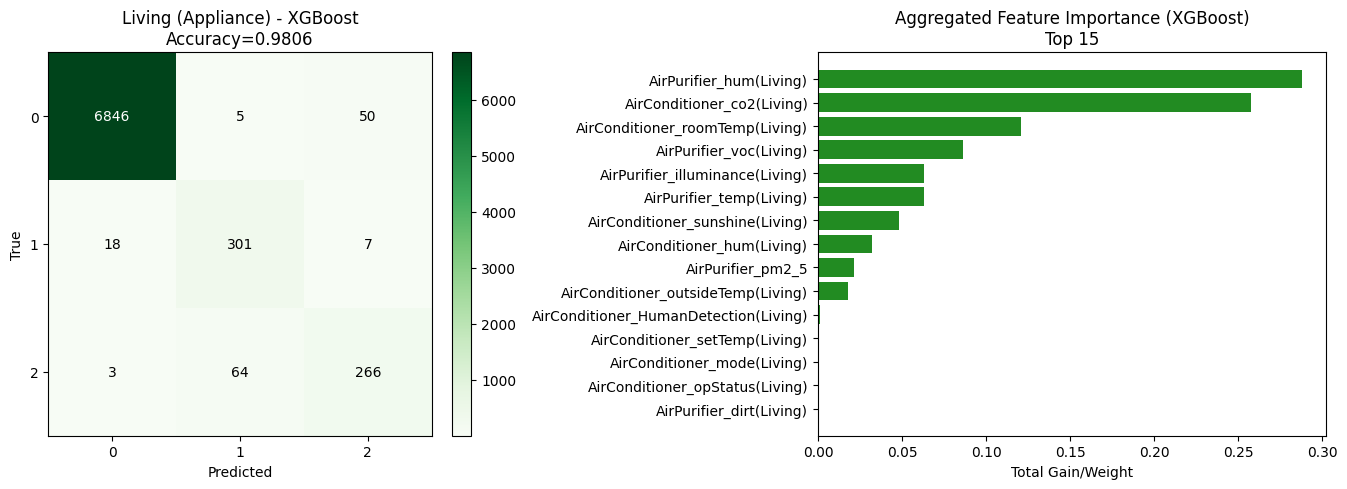


📥 Loading Japanese (All) data from: /content/和室.csv ...
  Features -> Numeric: 21, Event/Human: 3
  Train: 17527, Test: 7560

--- Result: Japanese [All] (XGBoost: 0/1/2) ---
              precision    recall  f1-score   support

           0      0.999     0.998     0.998      7121
           1      0.837     0.991     0.907       212
           2      0.990     0.863     0.922       227

    accuracy                          0.993      7560
   macro avg      0.942     0.951     0.943      7560
weighted avg      0.994     0.993     0.993      7560



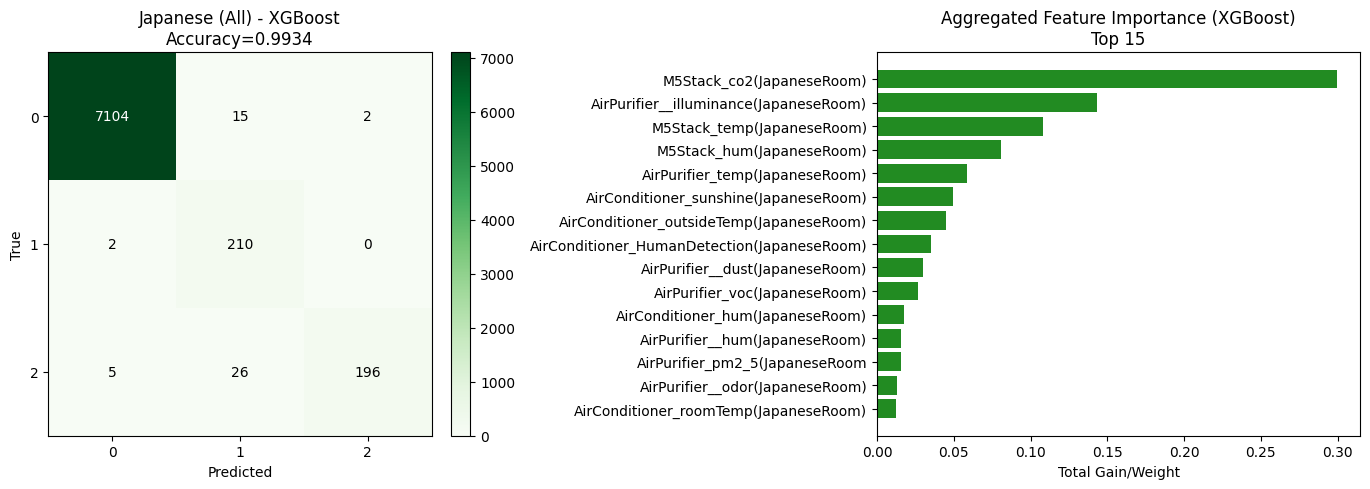


📥 Loading Japanese (Appliance) data from: /content/和室.csv ...
  Features -> Numeric: 18, Event/Human: 1
  Train: 17527, Test: 7560

--- Result: Japanese [Appliance] (XGBoost: 0/1/2) ---
              precision    recall  f1-score   support

           0      0.995     0.996     0.996      7121
           1      0.792     0.896     0.841       212
           2      0.944     0.815     0.875       227

    accuracy                          0.988      7560
   macro avg      0.910     0.902     0.904      7560
weighted avg      0.988     0.988     0.988      7560



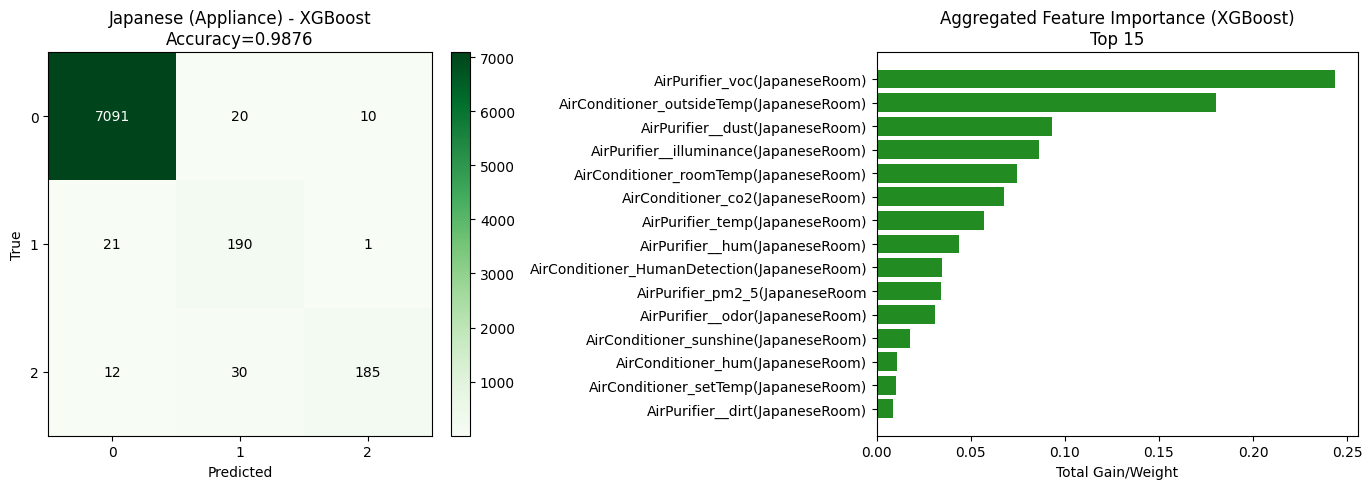


✅ Done.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import xgboost as xgb  # XGBoostをインポート

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =========================
# Config
# =========================
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

# 窓幅 (分)
WINS = [5, 10, 15, 20, 25, 30, 60]

TOPK_IMPORTANCE = 15
SEED = 42
BLOCK_MINUTES = 30
TEST_RATIO = 0.30

LABEL_COLS = [
    "Label_Living_Action",
    "Label_Living_Count",
    "Label_Japanese_Count",
    "Label_Japanese_Action",
    "Label_Total_People"
]

# =========================
# Utilities
# =========================
def fix_timestamp_robust(df: pd.DataFrame, col: str) -> pd.Series:
    s = df[col].astype(str)
    if s.iloc[0].startswith("20") and "-" in s.iloc[0]:
        return pd.to_datetime(s, errors="coerce")
    try:
        temp_dates = pd.to_datetime(s, format='%M:%S.%f', errors='coerce')
    except:
        temp_dates = pd.to_datetime(s, errors='coerce')
    if temp_dates.isna().mean() > 0.5:
         temp_dates = pd.to_datetime(s, errors='coerce')
    diff = temp_dates.diff()
    wrap_indices = diff < pd.Timedelta(minutes=-30)
    hours_to_add = wrap_indices.cumsum()
    return temp_dates + pd.to_timedelta(hours_to_add, unit='h')

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]
    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())
    if not out: return pd.DataFrame()
    dfr = pd.concat(out, axis=1).sort_index()
    return safe_ffill(dfr).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

# ---------------------------------------------------------
# Feature Importance Aggregation
# ---------------------------------------------------------
def aggregate_importances(feature_names, importances):
    base_names = []
    # 末尾の派生語を除去
    pattern = re.compile(r'(_diff|_mean_\d+|_std_\d+|_slope_\d+|_sum_\d+)$')

    for name in feature_names:
        base = pattern.sub('', name)
        base_names.append(base)

    df_imp = pd.DataFrame({'feature': base_names, 'importance': importances})
    grouped = df_imp.groupby('feature')['importance'].sum().sort_values(ascending=False)
    return grouped

def plot_cm_and_importance_xgb(title, y_true, y_pred, labels, feature_names, importances, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    fig = plt.figure(figsize=(14, 5))

    # 1. CM
    ax1 = plt.subplot(1, 2, 1)
    # XGBoostカラーっぽく緑系で(公式ロゴ意識)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Greens")
    ax1.set_title(f"{title}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(labels); ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = "white" if cm[i, j] > cm.max()/2 else "black"
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color=text_color)

    # 2. Importance
    ax2 = plt.subplot(1, 2, 2)
    agg_imp = aggregate_importances(feature_names, importances)
    top = agg_imp.head(topk)[::-1]

    ax2.barh(top.index, top.values, color="forestgreen")
    ax2.set_title(f"Aggregated Feature Importance (XGBoost)\nTop {topk}")
    ax2.set_xlabel("Total Gain/Weight")

    plt.tight_layout()
    plt.show()

# =========================
# Feature Engineering
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3: return pd.Series(0.0, index=y.index)
    return (y - y.shift(w)).fillna(0.0) / w

def build_numeric_features(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns: continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)
        feats[c] = s
        feats[f"{c}_diff"] = s.diff().fillna(0.0)
        for w in wins:
            feats[f"{c}_mean_{w}"] = s.rolling(w).mean().fillna(0.0)
            feats[f"{c}_std_{w}"]  = s.rolling(w).std().fillna(0.0)
            feats[f"{c}_slope_{w}"] = _rolling_linreg_slope(s, w)
    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X.loc[:, ~X.columns.duplicated()]

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns: continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}"] = s.rolling(w).sum().fillna(0.0)
    X = pd.DataFrame(feats, index=df.index)
    return X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# =========================
# Main Logic (XGBoost)
# =========================
def run_xgb_analysis(filename: str, room: str, target_col: str, mode: str = "All"):
    """
    mode: "All" or "Appliance"
    target: 0/1/2 (Multiclass)
    """
    print(f"\n📥 Loading {room} ({mode}) data from: {filename} ...")
    try:
        df0 = pd.read_csv(filename, low_memory=False)
    except UnicodeDecodeError:
        df0 = pd.read_csv(filename, low_memory=False, encoding='cp932')

    if TIME_COL not in df0.columns: return
    if target_col not in df0.columns: return

    # Timestamp
    df0[TIME_COL] = fix_timestamp_robust(df0, TIME_COL)
    df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)
    df0 = safe_ffill(df0).fillna(0.0)

    # Resample
    df = resample_1min(df0, RESAMPLE_RULE)

    # Label (0, 1, 2)
    y = pd.to_numeric(df[target_col], errors="coerce").fillna(0).astype(int)
    y = y.apply(lambda x: x if x in [0, 1, 2] else 0)

    # Feature Selection
    all_cols = [c for c in df.columns if c not in LABEL_COLS]

    if mode == "Appliance":
        target_cols = [c for c in all_cols if "AirPurifier" in c or "AirConditioner" in c]
    else:
        target_cols = all_cols

    hum_cols = [c for c in target_cols if "human" in c.lower() or "pir" in c.lower() or "motion" in c.lower()]
    num_cols = [c for c in target_cols if c not in hum_cols]

    print(f"  Features -> Numeric: {len(num_cols)}, Event/Human: {len(hum_cols)}")

    # 特徴量作成
    X_num = build_numeric_features(df, num_cols, WINS)
    X_hum = build_human_features(df, hum_cols, WINS)
    X = pd.concat([X_num, X_hum], axis=1).fillna(0.0)

    # XGBoostはFeature名に[]などの記号があっても比較的大丈夫ですが、念のため重複除去のみ確認
    X = X.loc[:, ~X.columns.duplicated()]

    # Split
    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_te, y_te = X.iloc[te_idx], y.iloc[te_idx]

    print(f"  Train: {len(X_tr)}, Test: {len(X_te)}")

    # XGBoost Model
    model = xgb.XGBClassifier(
        objective='multi:softprob', # 多クラス分類
        num_class=3,
        n_estimators=800,
        learning_rate=0.05,
        max_depth=6,
        random_state=SEED,
        n_jobs=-1,
        # クラス不均衡対策用重み付けはXGBoostでは直接引数がないため
        # 簡易的にはsample_weightで対応するか、ここではデフォルトで実行します
    )

    # 必要ならsample_weightを計算して fit に渡すことも可能ですが、
    # ここではシンプルに実行します
    model.fit(X_tr, y_tr)

    pred = model.predict(X_te)

    # Report
    print(f"\n--- Result: {room} [{mode}] (XGBoost: 0/1/2) ---")
    print(classification_report(y_te, pred, digits=3, zero_division=0))

    # Plot
    plot_cm_and_importance_xgb(
        f"{room} ({mode}) - XGBoost",
        y_te, pred, [0, 1, 2],
        X.columns, model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

# =========================
# Execution
# =========================

# 1. Living Analysis
run_xgb_analysis("/content/リビング.csv", "Living", "Label_Living_Count", mode="All")
run_xgb_analysis("/content/リビング.csv", "Living", "Label_Living_Count", mode="Appliance")

# 2. Japanese Room Analysis
run_xgb_analysis("/content/和室.csv", "Japanese", "Label_Japanese_Count", mode="All")
run_xgb_analysis("/content/和室.csv", "Japanese", "Label_Japanese_Count", mode="Appliance")

print("\n✅ Done.")


📥 Loading Living (All) data from: /content/リビング.csv ...
  Features -> Numeric: 25, Event/Human: 6
  Train: 17591, Test: 7560

--- Result: Living [All] (LightGBM: 0 vs 1+) ---
              precision    recall  f1-score   support

       Empty      0.998     0.987     0.992      6901
    Occupied      0.877     0.976     0.924       659

    accuracy                          0.986      7560
   macro avg      0.937     0.981     0.958      7560
weighted avg      0.987     0.986     0.986      7560



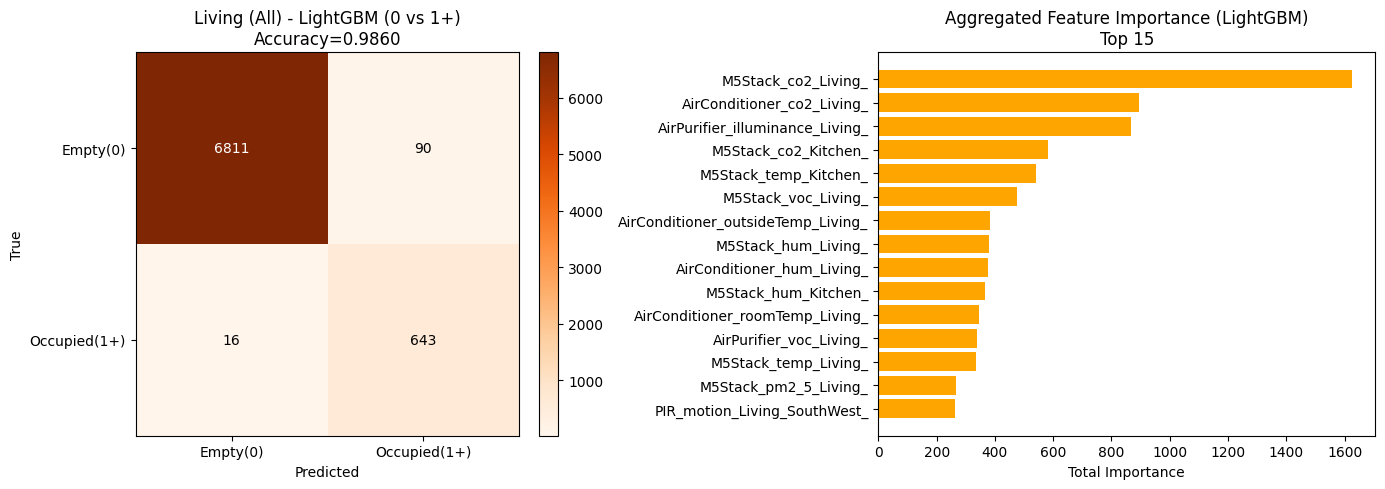


📥 Loading Living (Appliance) data from: /content/リビング.csv ...
  Features -> Numeric: 17, Event/Human: 1
  Train: 17591, Test: 7560

--- Result: Living [Appliance] (LightGBM: 0 vs 1+) ---
              precision    recall  f1-score   support

       Empty      0.999     0.987     0.992      6901
    Occupied      0.875     0.985     0.926       659

    accuracy                          0.986      7560
   macro avg      0.937     0.986     0.959      7560
weighted avg      0.988     0.986     0.987      7560



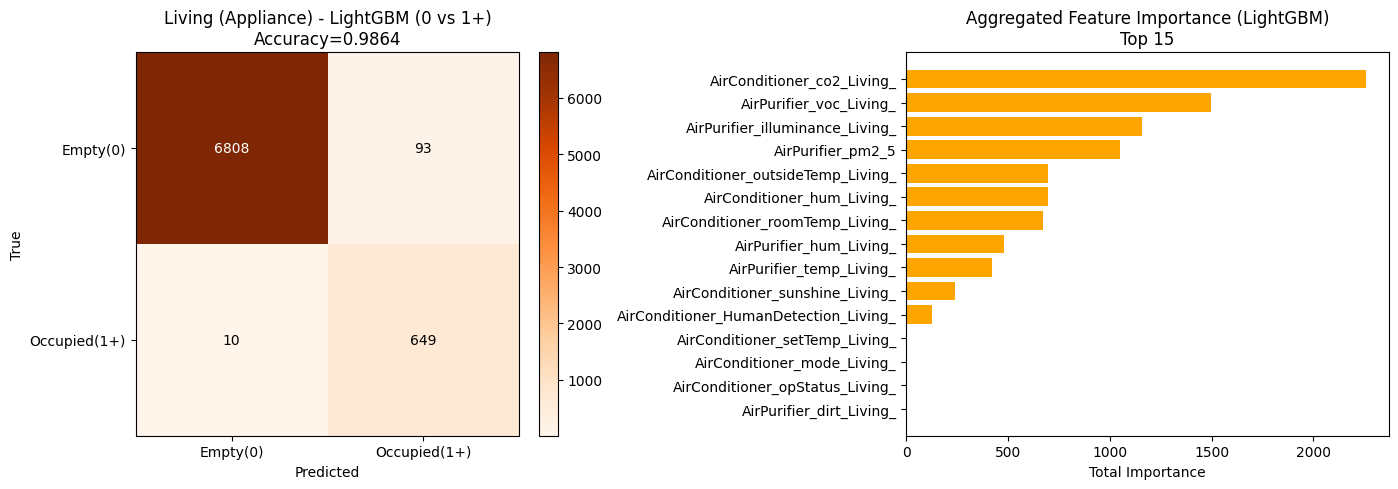


📥 Loading Japanese (All) data from: /content/和室.csv ...
  Features -> Numeric: 21, Event/Human: 3
  Train: 17527, Test: 7560

--- Result: Japanese [All] (LightGBM: 0 vs 1+) ---
              precision    recall  f1-score   support

       Empty      0.999     0.996     0.998      7121
    Occupied      0.943     0.984     0.963       439

    accuracy                          0.996      7560
   macro avg      0.971     0.990     0.980      7560
weighted avg      0.996     0.996     0.996      7560



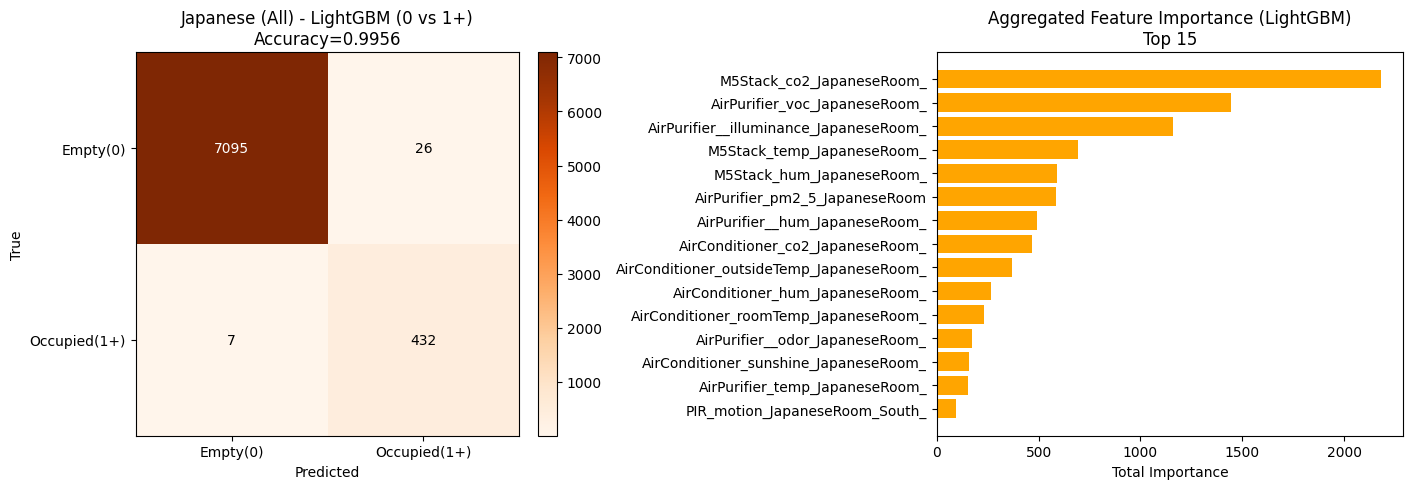


📥 Loading Japanese (Appliance) data from: /content/和室.csv ...
  Features -> Numeric: 18, Event/Human: 1
  Train: 17527, Test: 7560

--- Result: Japanese [Appliance] (LightGBM: 0 vs 1+) ---
              precision    recall  f1-score   support

       Empty      0.998     0.995     0.997      7121
    Occupied      0.924     0.973     0.948       439

    accuracy                          0.994      7560
   macro avg      0.961     0.984     0.972      7560
weighted avg      0.994     0.994     0.994      7560



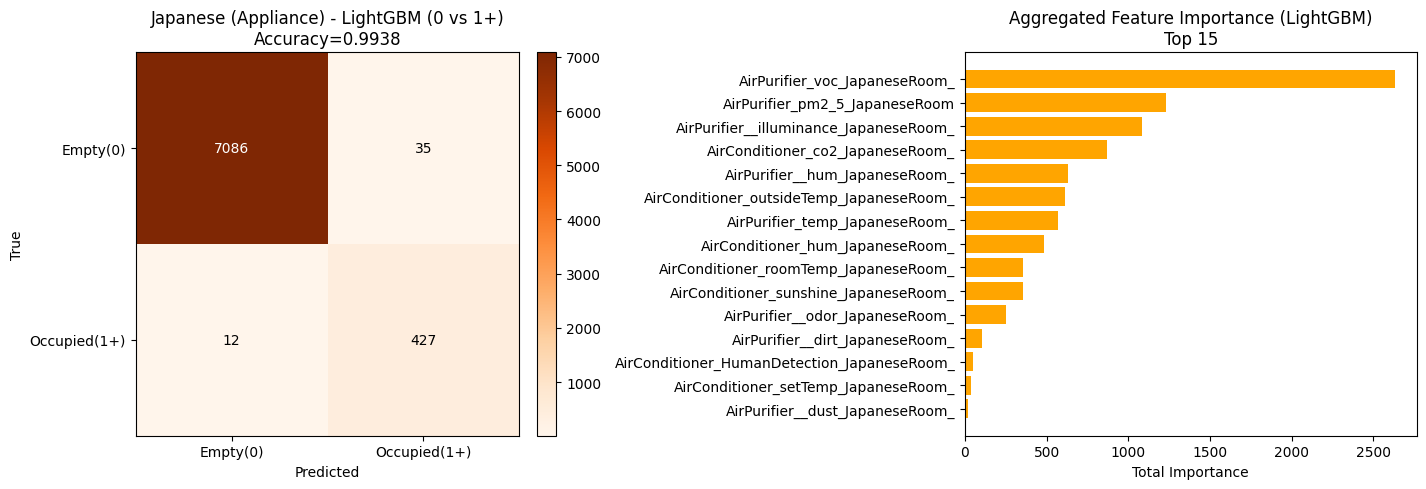


✅ Done.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import lightgbm as lgb

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =========================
# Config
# =========================
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

# 窓幅 (分)
# PIR等の累積(Sum)や統計量(Mean/Std)計算に使用
WINS = [5, 10, 15, 20, 25, 30, 60]

TOPK_IMPORTANCE = 15
SEED = 42
BLOCK_MINUTES = 30
TEST_RATIO = 0.30

LABEL_COLS = [
    "Label_Living_Action",
    "Label_Living_Count",
    "Label_Japanese_Count",
    "Label_Japanese_Action",
    "Label_Total_People"
]

# =========================
# Utilities
# =========================
def fix_timestamp_robust(df: pd.DataFrame, col: str) -> pd.Series:
    s = df[col].astype(str)
    if s.iloc[0].startswith("20") and "-" in s.iloc[0]:
        return pd.to_datetime(s, errors="coerce")
    try:
        temp_dates = pd.to_datetime(s, format='%M:%S.%f', errors='coerce')
    except:
        temp_dates = pd.to_datetime(s, errors='coerce')
    if temp_dates.isna().mean() > 0.5:
         temp_dates = pd.to_datetime(s, errors='coerce')
    diff = temp_dates.diff()
    wrap_indices = diff < pd.Timedelta(minutes=-30)
    hours_to_add = wrap_indices.cumsum()
    return temp_dates + pd.to_timedelta(hours_to_add, unit='h')

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]
    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())
    if not out: return pd.DataFrame()
    dfr = pd.concat(out, axis=1).sort_index()
    return safe_ffill(dfr).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """LightGBM用にカラム名の特殊文字を除去"""
    new_cols = []
    for c in df.columns:
        c_clean = re.sub(r'[(),\[\]]', '_', c)
        new_cols.append(c_clean)
    df.columns = new_cols
    return df

# ---------------------------------------------------------
# Feature Importance Aggregation
# ---------------------------------------------------------
def aggregate_importances(feature_names, importances):
    base_names = []
    # 末尾の _sum_5, _mean_10, _diff などを除去してベースセンサー名を取得
    pattern = re.compile(r'(_diff|_mean_\d+|_std_\d+|_slope_\d+|_sum_\d+)$')

    for name in feature_names:
        base = pattern.sub('', name)
        base_names.append(base)

    df_imp = pd.DataFrame({'feature': base_names, 'importance': importances})
    grouped = df_imp.groupby('feature')['importance'].sum().sort_values(ascending=False)
    return grouped

def plot_cm_and_importance_binary(title, y_true, y_pred, labels, feature_names, importances, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    fig = plt.figure(figsize=(14, 5))

    # 1. Confusion Matrix
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Oranges") # LightGBMカラー
    ax1.set_title(f"{title}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(["Empty(0)", "Occupied(1+)"]); ax1.set_yticklabels(["Empty(0)", "Occupied(1+)"])
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = "white" if cm[i, j] > cm.max()/2 else "black"
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color=text_color)

    # 2. Aggregated Feature Importance
    ax2 = plt.subplot(1, 2, 2)
    agg_imp = aggregate_importances(feature_names, importances)
    top = agg_imp.head(topk)[::-1]

    ax2.barh(top.index, top.values, color="orange")
    ax2.set_title(f"Aggregated Feature Importance (LightGBM)\nTop {topk}")
    ax2.set_xlabel("Total Importance")

    plt.tight_layout()
    plt.show()

# =========================
# Feature Engineering
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3: return pd.Series(0.0, index=y.index)
    return (y - y.shift(w)).fillna(0.0) / w

def build_numeric_features(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns: continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)
        feats[c] = s
        feats[f"{c}_diff"] = s.diff().fillna(0.0)
        for w in wins:
            feats[f"{c}_mean_{w}"] = s.rolling(w).mean().fillna(0.0)
            feats[f"{c}_std_{w}"]  = s.rolling(w).std().fillna(0.0)
            feats[f"{c}_slope_{w}"] = _rolling_linreg_slope(s, w)
    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X.loc[:, ~X.columns.duplicated()]

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns: continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            # 2値分類(在室検知)ではPIRの累積反応(Sum)が特に効く傾向があります
            feats[f"{c}_sum_{w}"] = s.rolling(w).sum().fillna(0.0)
    X = pd.DataFrame(feats, index=df.index)
    return X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# =========================
# Main Logic (LightGBM Binary)
# =========================
def run_lgbm_binary(filename: str, room: str, target_col: str, mode: str = "All"):
    """
    mode: "All" (全センサー) or "Appliance" (家電のみ)
    target: 0 vs 1+ (Binary)
    """
    print(f"\n📥 Loading {room} ({mode}) data from: {filename} ...")
    try:
        df0 = pd.read_csv(filename, low_memory=False)
    except UnicodeDecodeError:
        df0 = pd.read_csv(filename, low_memory=False, encoding='cp932')

    if TIME_COL not in df0.columns: return
    if target_col not in df0.columns: return

    # Timestamp
    df0[TIME_COL] = fix_timestamp_robust(df0, TIME_COL)
    df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)
    df0 = safe_ffill(df0).fillna(0.0)

    # Resample
    df = resample_1min(df0, RESAMPLE_RULE)

    # ----------------------------------------
    # Label Binarization: 0 vs 1+
    # ----------------------------------------
    y_raw = pd.to_numeric(df[target_col], errors="coerce").fillna(0).astype(int)
    y = (y_raw > 0).astype(int) # 0->0, 1以上->1

    # Feature Selection
    all_cols = [c for c in df.columns if c not in LABEL_COLS]

    if mode == "Appliance":
        # 家電関連のみ抽出
        target_cols = [c for c in all_cols if "AirPurifier" in c or "AirConditioner" in c]
    else:
        # すべて
        target_cols = all_cols

    # 数値系と人感系に分離
    hum_cols = [c for c in target_cols if "human" in c.lower() or "pir" in c.lower() or "motion" in c.lower()]
    num_cols = [c for c in target_cols if c not in hum_cols]

    print(f"  Features -> Numeric: {len(num_cols)}, Event/Human: {len(hum_cols)}")

    # 特徴量作成
    X_num = build_numeric_features(df, num_cols, WINS)
    X_hum = build_human_features(df, hum_cols, WINS)
    X = pd.concat([X_num, X_hum], axis=1).fillna(0.0)

    # Clean Column Names for LightGBM
    X = clean_column_names(X)

    # Split
    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_te, y_te = X.iloc[te_idx], y.iloc[te_idx]

    print(f"  Train: {len(X_tr)}, Test: {len(X_te)}")

    # LightGBM Model (Binary)
    model = lgb.LGBMClassifier(
        objective='binary',   # 2値分類
        metric='binary_logloss',
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        random_state=SEED,
        n_jobs=-1,
        class_weight='balanced', # 不均衡データ対策(0が多い場合など)
        verbose=-1
    )

    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)

    # Report
    print(f"\n--- Result: {room} [{mode}] (LightGBM: 0 vs 1+) ---")
    print(classification_report(y_te, pred, target_names=["Empty", "Occupied"], digits=3))

    # Plot
    plot_cm_and_importance_binary(
        f"{room} ({mode}) - LightGBM (0 vs 1+)",
        y_te, pred, [0, 1],
        X.columns, model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

# =========================
# Execution
# =========================

# 1. Living Analysis
run_lgbm_binary("/content/リビング.csv", "Living", "Label_Living_Count", mode="All")
run_lgbm_binary("/content/リビング.csv", "Living", "Label_Living_Count", mode="Appliance")

# 2. Japanese Room Analysis
run_lgbm_binary("/content/和室.csv", "Japanese", "Label_Japanese_Count", mode="All")
run_lgbm_binary("/content/和室.csv", "Japanese", "Label_Japanese_Count", mode="Appliance")

print("\n✅ Done.")


📥 Loading Living (All) data from: /content/リビング.csv ...
  Features -> Numeric: 25, Event/Human: 6
  Train: 17591, Test: 7560

--- Result: Living [All] (XGBoost: 0 vs 1+) ---
              precision    recall  f1-score   support

       Empty      0.998     0.987     0.992      6901
    Occupied      0.876     0.976     0.923       659

    accuracy                          0.986      7560
   macro avg      0.937     0.981     0.958      7560
weighted avg      0.987     0.986     0.986      7560



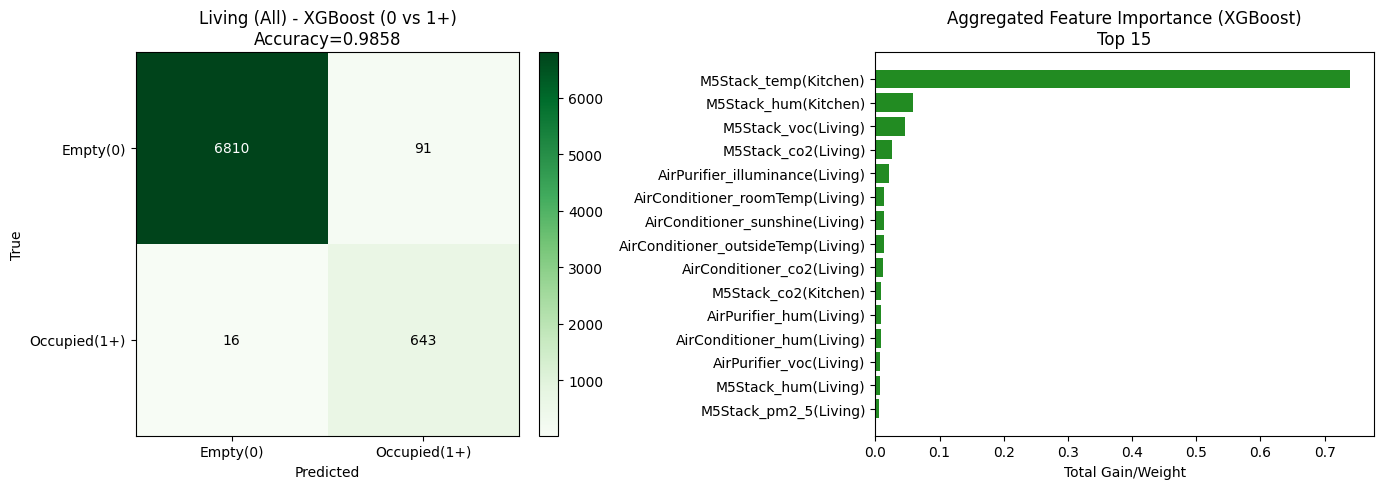


📥 Loading Living (Appliance) data from: /content/リビング.csv ...
  Features -> Numeric: 17, Event/Human: 1
  Train: 17591, Test: 7560

--- Result: Living [Appliance] (XGBoost: 0 vs 1+) ---
              precision    recall  f1-score   support

       Empty      0.999     0.982     0.990      6901
    Occupied      0.839     0.986     0.907       659

    accuracy                          0.982      7560
   macro avg      0.919     0.984     0.948      7560
weighted avg      0.985     0.982     0.983      7560



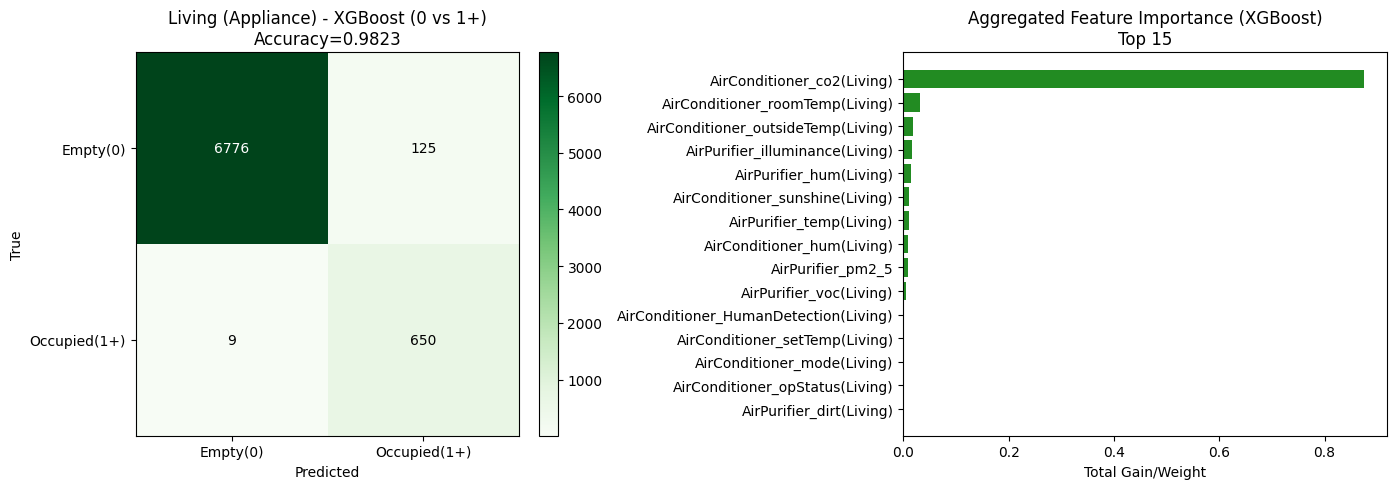


📥 Loading Japanese (All) data from: /content/和室.csv ...
  Features -> Numeric: 21, Event/Human: 3
  Train: 17527, Test: 7560

--- Result: Japanese [All] (XGBoost: 0 vs 1+) ---
              precision    recall  f1-score   support

       Empty      0.999     0.996     0.998      7121
    Occupied      0.944     0.991     0.967       439

    accuracy                          0.996      7560
   macro avg      0.972     0.994     0.982      7560
weighted avg      0.996     0.996     0.996      7560



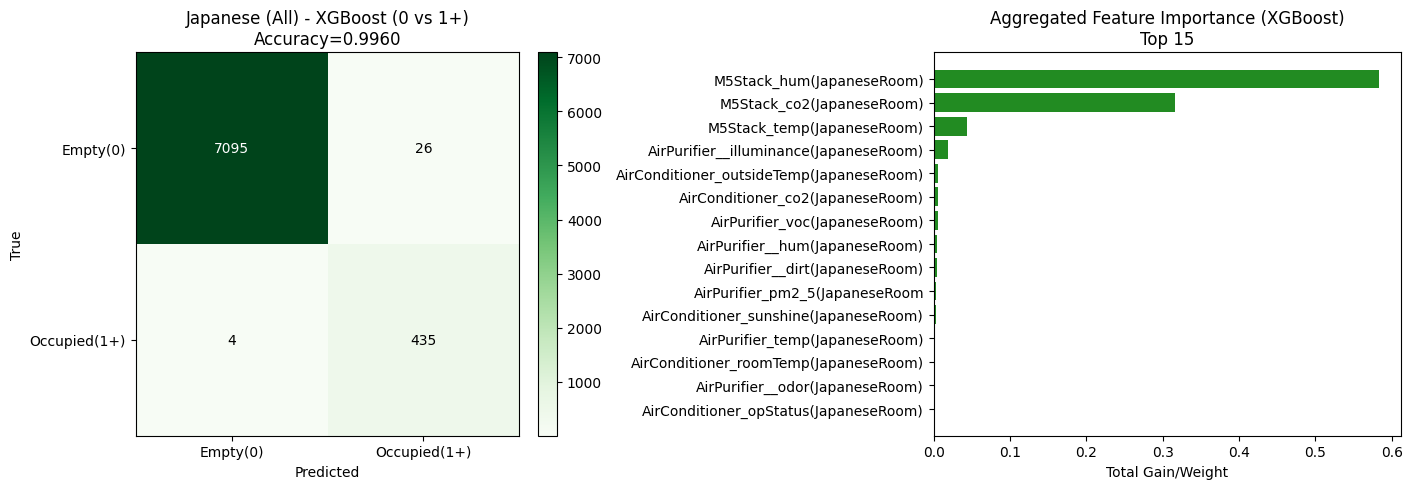


📥 Loading Japanese (Appliance) data from: /content/和室.csv ...
  Features -> Numeric: 18, Event/Human: 1
  Train: 17527, Test: 7560

--- Result: Japanese [Appliance] (XGBoost: 0 vs 1+) ---
              precision    recall  f1-score   support

       Empty      0.999     0.994     0.996      7121
    Occupied      0.909     0.977     0.942       439

    accuracy                          0.993      7560
   macro avg      0.954     0.986     0.969      7560
weighted avg      0.993     0.993     0.993      7560



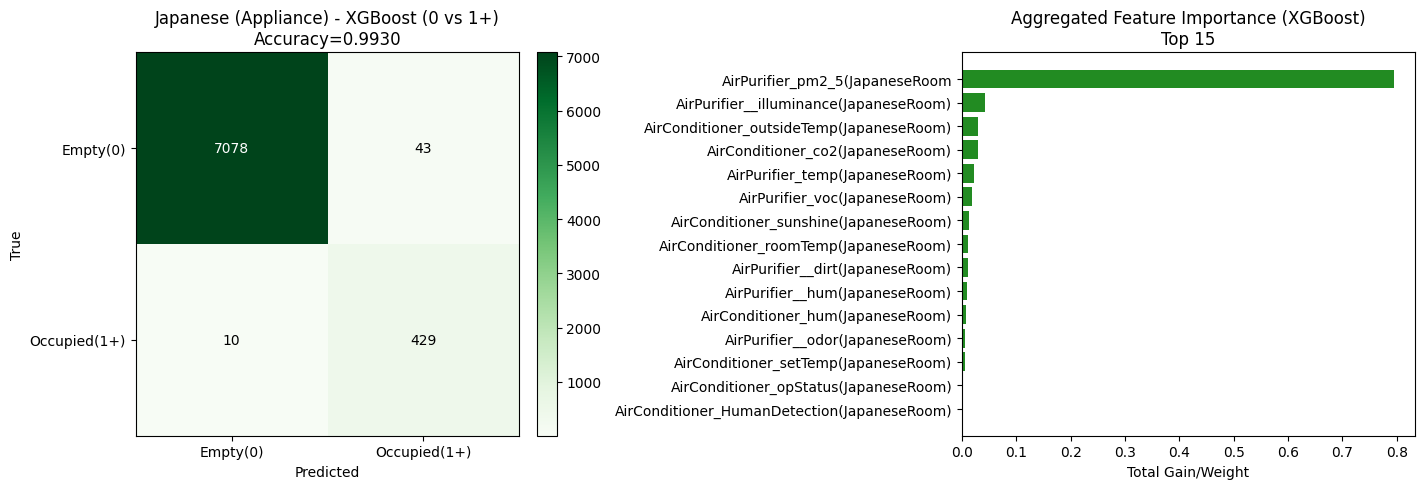


✅ Done.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import xgboost as xgb

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =========================
# Config
# =========================
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

# 窓幅 (分)
# PIR等の累積(Sum)や統計量(Mean/Std)計算に使用
WINS = [5, 10, 15, 20, 25, 30, 60]

TOPK_IMPORTANCE = 15
SEED = 42
BLOCK_MINUTES = 30
TEST_RATIO = 0.30

LABEL_COLS = [
    "Label_Living_Action",
    "Label_Living_Count",
    "Label_Japanese_Count",
    "Label_Japanese_Action",
    "Label_Total_People"
]

# =========================
# Utilities
# =========================
def fix_timestamp_robust(df: pd.DataFrame, col: str) -> pd.Series:
    s = df[col].astype(str)
    if s.iloc[0].startswith("20") and "-" in s.iloc[0]:
        return pd.to_datetime(s, errors="coerce")
    try:
        temp_dates = pd.to_datetime(s, format='%M:%S.%f', errors='coerce')
    except:
        temp_dates = pd.to_datetime(s, errors='coerce')
    if temp_dates.isna().mean() > 0.5:
         temp_dates = pd.to_datetime(s, errors='coerce')
    diff = temp_dates.diff()
    wrap_indices = diff < pd.Timedelta(minutes=-30)
    hours_to_add = wrap_indices.cumsum()
    return temp_dates + pd.to_timedelta(hours_to_add, unit='h')

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]
    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())
    if not out: return pd.DataFrame()
    dfr = pd.concat(out, axis=1).sort_index()
    return safe_ffill(dfr).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

# ---------------------------------------------------------
# Feature Importance Aggregation
# ---------------------------------------------------------
def aggregate_importances(feature_names, importances):
    base_names = []
    # 末尾の派生サフィックスを除去してベースセンサー名を取得
    pattern = re.compile(r'(_diff|_mean_\d+|_std_\d+|_slope_\d+|_sum_\d+)$')

    for name in feature_names:
        base = pattern.sub('', name)
        base_names.append(base)

    df_imp = pd.DataFrame({'feature': base_names, 'importance': importances})
    grouped = df_imp.groupby('feature')['importance'].sum().sort_values(ascending=False)
    return grouped

def plot_cm_and_importance_xgb_binary(title, y_true, y_pred, labels, feature_names, importances, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    fig = plt.figure(figsize=(14, 5))

    # 1. Confusion Matrix
    ax1 = plt.subplot(1, 2, 1)
    # XGBoostカラー (Green系)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Greens")
    ax1.set_title(f"{title}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(["Empty(0)", "Occupied(1+)"]); ax1.set_yticklabels(["Empty(0)", "Occupied(1+)"])
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = "white" if cm[i, j] > cm.max()/2 else "black"
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color=text_color)

    # 2. Aggregated Feature Importance
    ax2 = plt.subplot(1, 2, 2)
    agg_imp = aggregate_importances(feature_names, importances)
    top = agg_imp.head(topk)[::-1]

    ax2.barh(top.index, top.values, color="forestgreen")
    ax2.set_title(f"Aggregated Feature Importance (XGBoost)\nTop {topk}")
    ax2.set_xlabel("Total Gain/Weight")

    plt.tight_layout()
    plt.show()

# =========================
# Feature Engineering
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3: return pd.Series(0.0, index=y.index)
    return (y - y.shift(w)).fillna(0.0) / w

def build_numeric_features(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns: continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)
        feats[c] = s
        feats[f"{c}_diff"] = s.diff().fillna(0.0)
        for w in wins:
            feats[f"{c}_mean_{w}"] = s.rolling(w).mean().fillna(0.0)
            feats[f"{c}_std_{w}"]  = s.rolling(w).std().fillna(0.0)
            feats[f"{c}_slope_{w}"] = _rolling_linreg_slope(s, w)
    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X.loc[:, ~X.columns.duplicated()]

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns: continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            # 2値分類(在室検知)ではPIRの累積反応(Sum)が有効
            feats[f"{c}_sum_{w}"] = s.rolling(w).sum().fillna(0.0)
    X = pd.DataFrame(feats, index=df.index)
    return X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# =========================
# Main Logic (XGBoost Binary)
# =========================
def run_xgb_binary(filename: str, room: str, target_col: str, mode: str = "All"):
    """
    mode: "All" (全センサー) or "Appliance" (家電のみ)
    target: 0 vs 1+ (Binary)
    """
    print(f"\n📥 Loading {room} ({mode}) data from: {filename} ...")
    try:
        df0 = pd.read_csv(filename, low_memory=False)
    except UnicodeDecodeError:
        df0 = pd.read_csv(filename, low_memory=False, encoding='cp932')

    if TIME_COL not in df0.columns: return
    if target_col not in df0.columns: return

    # Timestamp
    df0[TIME_COL] = fix_timestamp_robust(df0, TIME_COL)
    df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)
    df0 = safe_ffill(df0).fillna(0.0)

    # Resample
    df = resample_1min(df0, RESAMPLE_RULE)

    # ----------------------------------------
    # Label Binarization: 0 vs 1+
    # ----------------------------------------
    y_raw = pd.to_numeric(df[target_col], errors="coerce").fillna(0).astype(int)
    y = (y_raw > 0).astype(int) # 0->0, 1以上->1

    # Feature Selection
    all_cols = [c for c in df.columns if c not in LABEL_COLS]

    if mode == "Appliance":
        # 家電関連のみ抽出
        target_cols = [c for c in all_cols if "AirPurifier" in c or "AirConditioner" in c]
    else:
        # すべて
        target_cols = all_cols

    # 数値系と人感系に分離
    hum_cols = [c for c in target_cols if "human" in c.lower() or "pir" in c.lower() or "motion" in c.lower()]
    num_cols = [c for c in target_cols if c not in hum_cols]

    print(f"  Features -> Numeric: {len(num_cols)}, Event/Human: {len(hum_cols)}")

    # 特徴量作成
    X_num = build_numeric_features(df, num_cols, WINS)
    X_hum = build_human_features(df, hum_cols, WINS)
    X = pd.concat([X_num, X_hum], axis=1).fillna(0.0)

    # Split
    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_te, y_te = X.iloc[te_idx], y.iloc[te_idx]

    print(f"  Train: {len(X_tr)}, Test: {len(X_te)}")

    # クラス不均衡対策 (0が多いので、1のウェイトを上げる)
    # scale_pos_weight = (count of 0) / (count of 1)
    num_neg = (y_tr == 0).sum()
    num_pos = (y_tr == 1).sum()
    scale_pos = num_neg / num_pos if num_pos > 0 else 1.0

    # XGBoost Model (Binary)
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=800,
        learning_rate=0.05,
        max_depth=6,
        scale_pos_weight=scale_pos, # 不均衡対策
        random_state=SEED,
        n_jobs=-1,
    )

    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)

    # Report
    print(f"\n--- Result: {room} [{mode}] (XGBoost: 0 vs 1+) ---")
    print(classification_report(y_te, pred, target_names=["Empty", "Occupied"], digits=3))

    # Plot
    plot_cm_and_importance_xgb_binary(
        f"{room} ({mode}) - XGBoost (0 vs 1+)",
        y_te, pred, [0, 1],
        X.columns, model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

# =========================
# Execution
# =========================

# 1. Living Analysis
run_xgb_binary("/content/リビング.csv", "Living", "Label_Living_Count", mode="All")
run_xgb_binary("/content/リビング.csv", "Living", "Label_Living_Count", mode="Appliance")

# 2. Japanese Room Analysis
run_xgb_binary("/content/和室.csv", "Japanese", "Label_Japanese_Count", mode="All")
run_xgb_binary("/content/和室.csv", "Japanese", "Label_Japanese_Count", mode="Appliance")

print("\n✅ Done.")


📥 Loading Living (All) data from: /content/リビング.csv ...
  Features -> Numeric: 25, Event/Human: 6
  Train: 17591, Test: 7560

--- Result: Living [All] (SVM: 0 vs 1+) ---
              precision    recall  f1-score   support

       Empty      0.997     0.994     0.995      6901
    Occupied      0.935     0.964     0.949       659

    accuracy                          0.991      7560
   macro avg      0.966     0.979     0.972      7560
weighted avg      0.991     0.991     0.991      7560



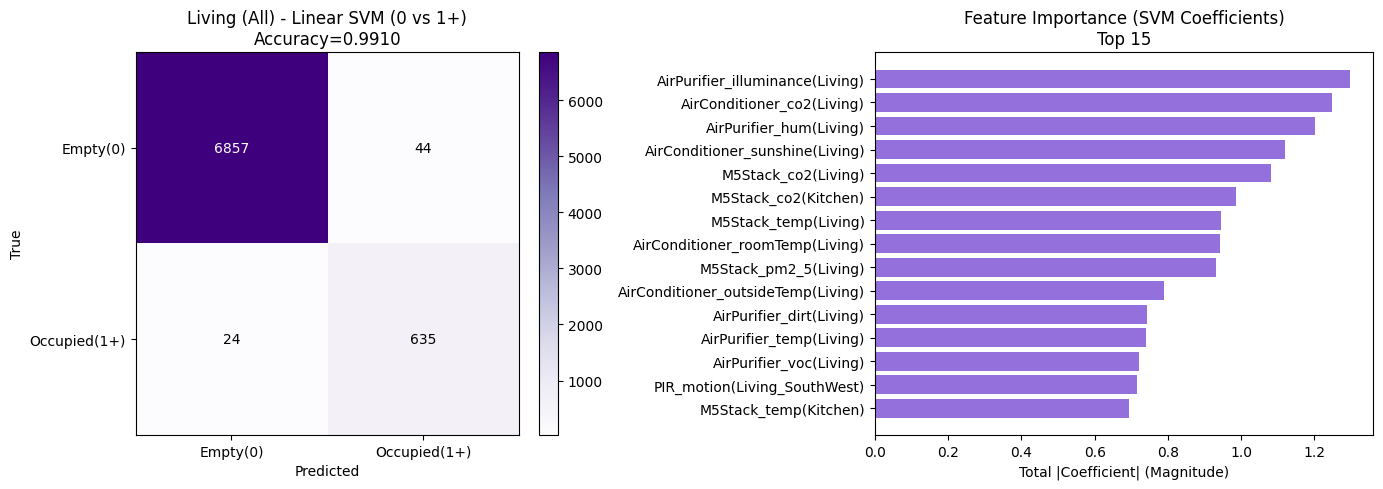


📥 Loading Living (Appliance) data from: /content/リビング.csv ...
  Features -> Numeric: 17, Event/Human: 1
  Train: 17591, Test: 7560

--- Result: Living [Appliance] (SVM: 0 vs 1+) ---
              precision    recall  f1-score   support

       Empty      0.991     0.982     0.987      6901
    Occupied      0.831     0.903     0.865       659

    accuracy                          0.976      7560
   macro avg      0.911     0.943     0.926      7560
weighted avg      0.977     0.976     0.976      7560



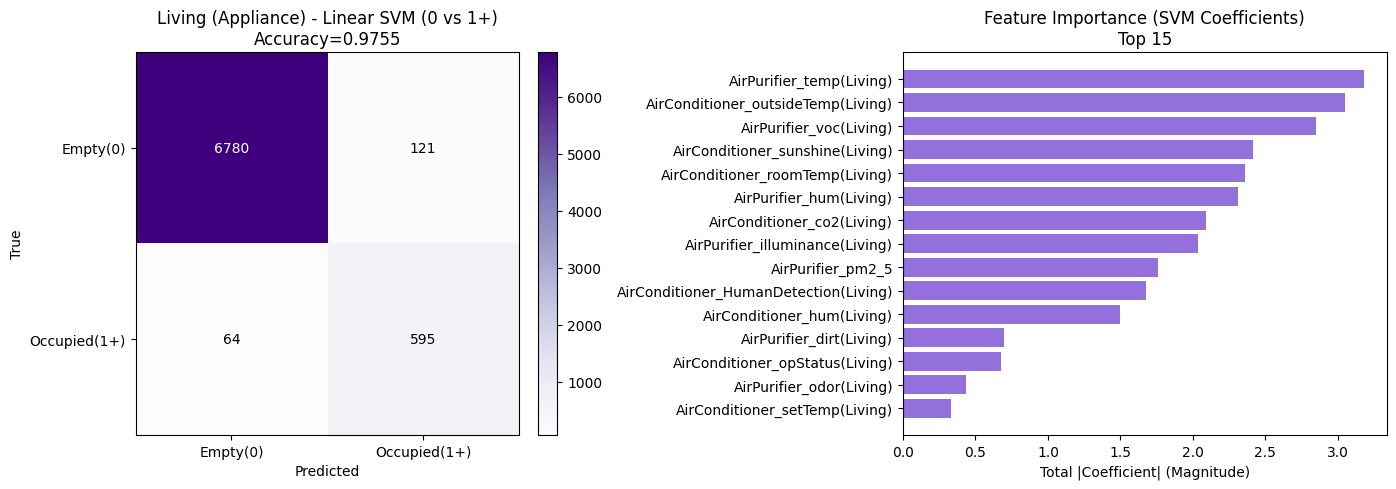


📥 Loading Japanese (All) data from: /content/和室.csv ...
  Features -> Numeric: 21, Event/Human: 3
  Train: 17527, Test: 7560

--- Result: Japanese [All] (SVM: 0 vs 1+) ---
              precision    recall  f1-score   support

       Empty      0.995     0.995     0.995      7121
    Occupied      0.918     0.918     0.918       439

    accuracy                          0.990      7560
   macro avg      0.956     0.956     0.956      7560
weighted avg      0.990     0.990     0.990      7560



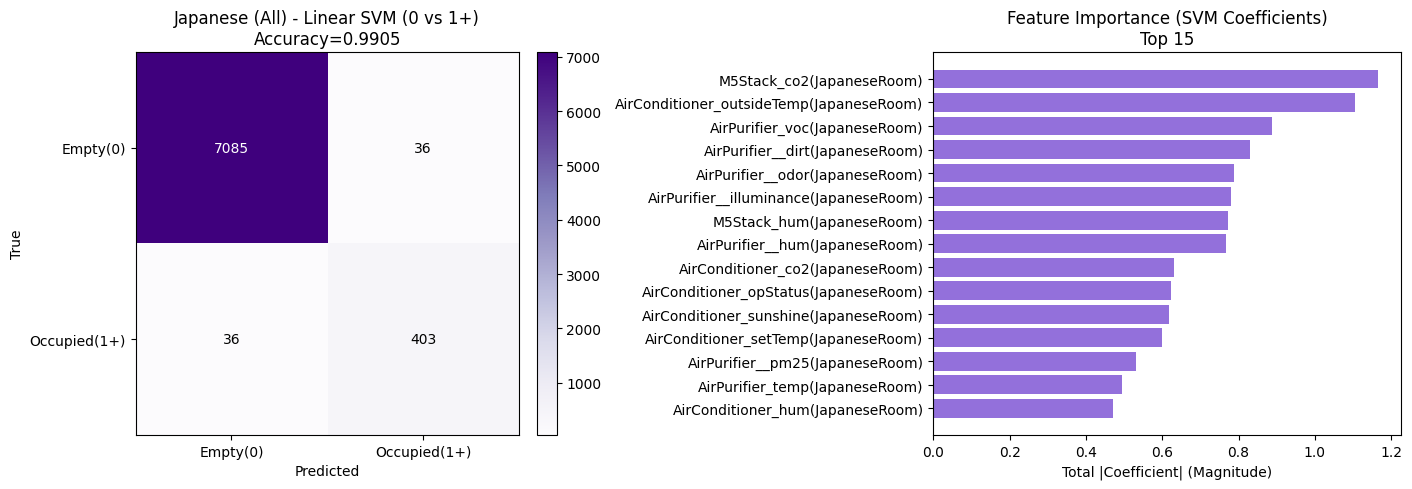


📥 Loading Japanese (Appliance) data from: /content/和室.csv ...
  Features -> Numeric: 18, Event/Human: 1
  Train: 17527, Test: 7560

--- Result: Japanese [Appliance] (SVM: 0 vs 1+) ---
              precision    recall  f1-score   support

       Empty      0.994     0.994     0.994      7121
    Occupied      0.908     0.895     0.901       439

    accuracy                          0.989      7560
   macro avg      0.951     0.945     0.948      7560
weighted avg      0.989     0.989     0.989      7560



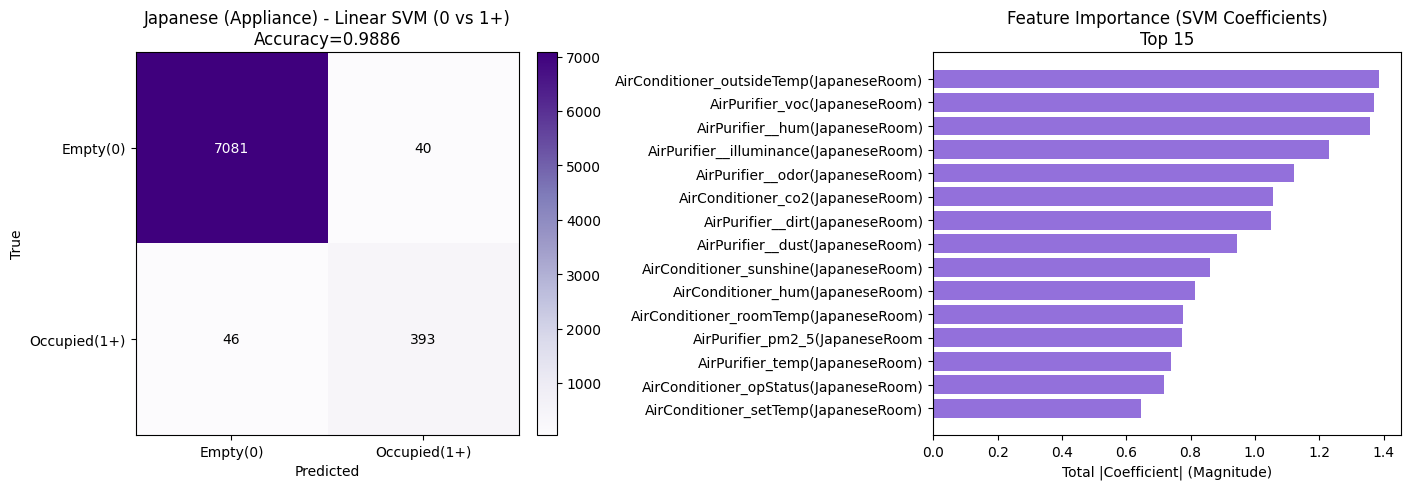


✅ Done.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =========================
# Config
# =========================
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

# 窓幅 (分)
WINS = [5, 10, 15, 20, 25, 30, 60]

TOPK_IMPORTANCE = 15
SEED = 42
BLOCK_MINUTES = 30
TEST_RATIO = 0.30

LABEL_COLS = [
    "Label_Living_Action",
    "Label_Living_Count",
    "Label_Japanese_Count",
    "Label_Japanese_Action",
    "Label_Total_People"
]

# =========================
# Utilities
# =========================
def fix_timestamp_robust(df: pd.DataFrame, col: str) -> pd.Series:
    s = df[col].astype(str)
    if s.iloc[0].startswith("20") and "-" in s.iloc[0]:
        return pd.to_datetime(s, errors="coerce")
    try:
        temp_dates = pd.to_datetime(s, format='%M:%S.%f', errors='coerce')
    except:
        temp_dates = pd.to_datetime(s, errors='coerce')
    if temp_dates.isna().mean() > 0.5:
         temp_dates = pd.to_datetime(s, errors='coerce')
    diff = temp_dates.diff()
    wrap_indices = diff < pd.Timedelta(minutes=-30)
    hours_to_add = wrap_indices.cumsum()
    return temp_dates + pd.to_timedelta(hours_to_add, unit='h')

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]
    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())
    if not out: return pd.DataFrame()
    dfr = pd.concat(out, axis=1).sort_index()
    return safe_ffill(dfr).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

# ---------------------------------------------------------
# Feature Importance Aggregation (Coefficient based)
# ---------------------------------------------------------
def aggregate_coefficients(feature_names, coefs):
    """
    SVMの係数(coef_)の絶対値を重要度として集約する
    """
    base_names = []
    # 絶対値をとることで、「プラスに効く」のも「マイナスに効く」のも重要度として扱う
    abs_coefs = np.abs(coefs)

    pattern = re.compile(r'(_diff|_mean_\d+|_std_\d+|_slope_\d+|_sum_\d+)$')

    for name in feature_names:
        base = pattern.sub('', name)
        base_names.append(base)

    df_imp = pd.DataFrame({'feature': base_names, 'importance': abs_coefs})
    # 合計してソート
    grouped = df_imp.groupby('feature')['importance'].sum().sort_values(ascending=False)
    return grouped

def plot_cm_and_importance_svm(title, y_true, y_pred, labels, feature_names, coefs, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    fig = plt.figure(figsize=(14, 5))

    # 1. Confusion Matrix
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Purples") # SVMカラー(イメージ)
    ax1.set_title(f"{title}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(["Empty(0)", "Occupied(1+)"]); ax1.set_yticklabels(["Empty(0)", "Occupied(1+)"])
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = "white" if cm[i, j] > cm.max()/2 else "black"
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color=text_color)

    # 2. Aggregated Importance (Coefficients)
    ax2 = plt.subplot(1, 2, 2)
    # SVMのcoef_は (1, n_features) の形なのでflattenする
    agg_imp = aggregate_coefficients(feature_names, coefs.flatten())
    top = agg_imp.head(topk)[::-1]

    ax2.barh(top.index, top.values, color="mediumpurple")
    ax2.set_title(f"Feature Importance (SVM Coefficients)\nTop {topk}")
    ax2.set_xlabel("Total |Coefficient| (Magnitude)")

    plt.tight_layout()
    plt.show()

# =========================
# Feature Engineering
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3: return pd.Series(0.0, index=y.index)
    return (y - y.shift(w)).fillna(0.0) / w

def build_numeric_features(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns: continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)
        feats[c] = s
        feats[f"{c}_diff"] = s.diff().fillna(0.0)
        for w in wins:
            feats[f"{c}_mean_{w}"] = s.rolling(w).mean().fillna(0.0)
            feats[f"{c}_std_{w}"]  = s.rolling(w).std().fillna(0.0)
            feats[f"{c}_slope_{w}"] = _rolling_linreg_slope(s, w)
    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X.loc[:, ~X.columns.duplicated()]

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns: continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}"] = s.rolling(w).sum().fillna(0.0)
    X = pd.DataFrame(feats, index=df.index)
    return X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# =========================
# Main Logic (SVM Binary)
# =========================
def run_svm_binary(filename: str, room: str, target_col: str, mode: str = "All"):
    """
    mode: "All" or "Appliance"
    target: 0 vs 1+ (Binary)
    """
    print(f"\n📥 Loading {room} ({mode}) data from: {filename} ...")
    try:
        df0 = pd.read_csv(filename, low_memory=False)
    except UnicodeDecodeError:
        df0 = pd.read_csv(filename, low_memory=False, encoding='cp932')

    if TIME_COL not in df0.columns: return
    if target_col not in df0.columns: return

    # Timestamp
    df0[TIME_COL] = fix_timestamp_robust(df0, TIME_COL)
    df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)
    df0 = safe_ffill(df0).fillna(0.0)

    # Resample
    df = resample_1min(df0, RESAMPLE_RULE)

    # Label (0 vs 1+)
    y_raw = pd.to_numeric(df[target_col], errors="coerce").fillna(0).astype(int)
    y = (y_raw > 0).astype(int)

    # Feature Selection
    all_cols = [c for c in df.columns if c not in LABEL_COLS]

    if mode == "Appliance":
        target_cols = [c for c in all_cols if "AirPurifier" in c or "AirConditioner" in c]
    else:
        target_cols = all_cols

    hum_cols = [c for c in target_cols if "human" in c.lower() or "pir" in c.lower() or "motion" in c.lower()]
    num_cols = [c for c in target_cols if c not in hum_cols]

    print(f"  Features -> Numeric: {len(num_cols)}, Event/Human: {len(hum_cols)}")

    # 特徴量作成
    X_num = build_numeric_features(df, num_cols, WINS)
    X_hum = build_human_features(df, hum_cols, WINS)
    X = pd.concat([X_num, X_hum], axis=1).fillna(0.0)

    # Split
    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_te, y_te = X.iloc[te_idx], y.iloc[te_idx]

    print(f"  Train: {len(X_tr)}, Test: {len(X_te)}")

    # SVM Model
    # 重要: SVMはスケーリング(StandardScaler)が必須
    # dual=False: サンプル数 > 特徴量数の場合に推奨される設定
    clf = make_pipeline(
        StandardScaler(),
        LinearSVC(random_state=SEED, dual=False, class_weight='balanced', max_iter=2000)
    )

    clf.fit(X_tr, y_tr)
    pred = clf.predict(X_te)

    # Report
    print(f"\n--- Result: {room} [{mode}] (SVM: 0 vs 1+) ---")
    print(classification_report(y_te, pred, target_names=["Empty", "Occupied"], digits=3))

    # 特徴量重要度 (LinearSVCの係数を取り出す)
    # Pipelineを使っているため、named_stepsからモデルを取り出す
    model = clf.named_steps['linearsvc']

    # Plot
    plot_cm_and_importance_svm(
        f"{room} ({mode}) - Linear SVM (0 vs 1+)",
        y_te, pred, [0, 1],
        X.columns, model.coef_,
        topk=TOPK_IMPORTANCE
    )

# =========================
# Execution
# =========================

# 1. Living Analysis
run_svm_binary("/content/リビング.csv", "Living", "Label_Living_Count", mode="All")
run_svm_binary("/content/リビング.csv", "Living", "Label_Living_Count", mode="Appliance")

# 2. Japanese Room Analysis
run_svm_binary("/content/和室.csv", "Japanese", "Label_Japanese_Count", mode="All")
run_svm_binary("/content/和室.csv", "Japanese", "Label_Japanese_Count", mode="Appliance")

print("\n✅ Done.")


📥 Loading Living (All) data from: /content/リビング.csv ...
  Features -> Numeric: 25, Event/Human: 6
  Train: 17591, Test: 7560

--- Result: Living [All] (SVM: 0/1/2) ---
              precision    recall  f1-score   support

           0      0.997     0.995     0.996      6901
           1      0.634     0.712     0.671       326
           2      0.698     0.646     0.671       333

    accuracy                          0.967      7560
   macro avg      0.776     0.784     0.779      7560
weighted avg      0.968     0.967     0.968      7560



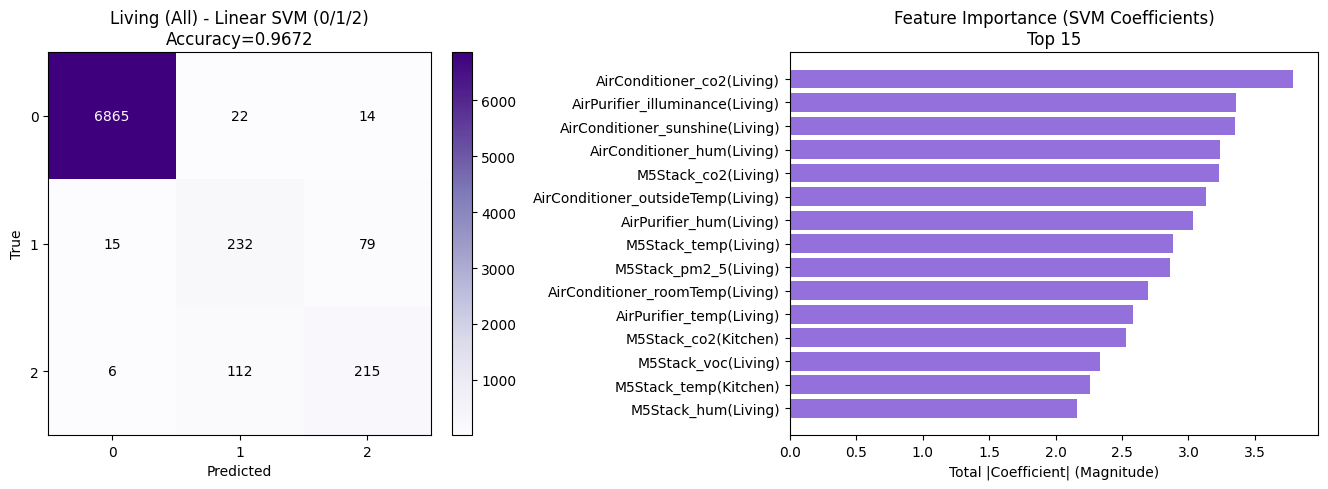


📥 Loading Living (Appliance) data from: /content/リビング.csv ...
  Features -> Numeric: 17, Event/Human: 1
  Train: 17591, Test: 7560

--- Result: Living [Appliance] (SVM: 0/1/2) ---
              precision    recall  f1-score   support

           0      0.992     0.989     0.991      6901
           1      0.611     0.718     0.660       326
           2      0.741     0.655     0.695       333

    accuracy                          0.963      7560
   macro avg      0.781     0.787     0.782      7560
weighted avg      0.964     0.963     0.963      7560



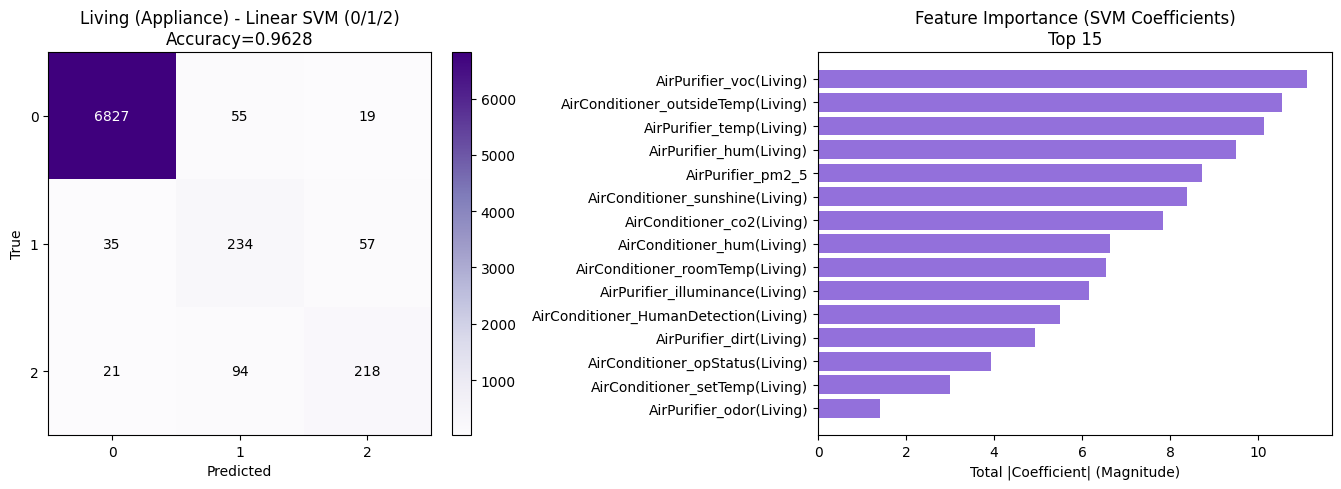


📥 Loading Japanese (All) data from: /content/和室.csv ...
  Features -> Numeric: 21, Event/Human: 3
  Train: 17527, Test: 7560

--- Result: Japanese [All] (SVM: 0/1/2) ---
              precision    recall  f1-score   support

           0      0.997     0.994     0.995      7121
           1      0.751     0.925     0.829       212
           2      0.990     0.859     0.920       227

    accuracy                          0.988      7560
   macro avg      0.912     0.926     0.915      7560
weighted avg      0.990     0.988     0.988      7560



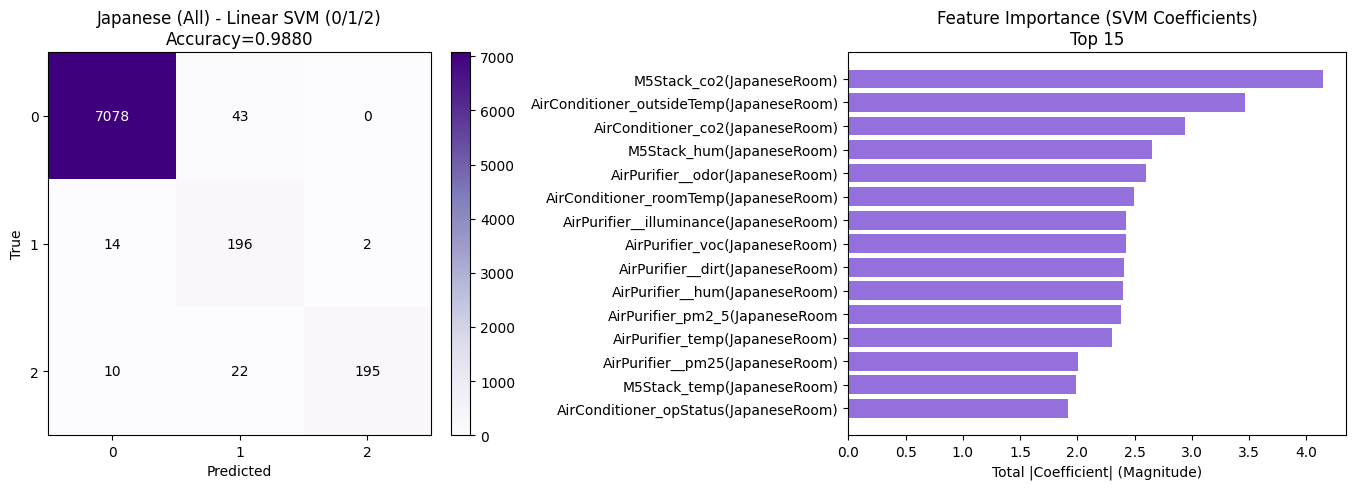


📥 Loading Japanese (Appliance) data from: /content/和室.csv ...
  Features -> Numeric: 18, Event/Human: 1
  Train: 17527, Test: 7560

--- Result: Japanese [Appliance] (SVM: 0/1/2) ---
              precision    recall  f1-score   support

           0      0.995     0.993     0.994      7121
           1      0.789     0.844     0.815       212
           2      0.905     0.877     0.890       227

    accuracy                          0.986      7560
   macro avg      0.896     0.905     0.900      7560
weighted avg      0.986     0.986     0.986      7560



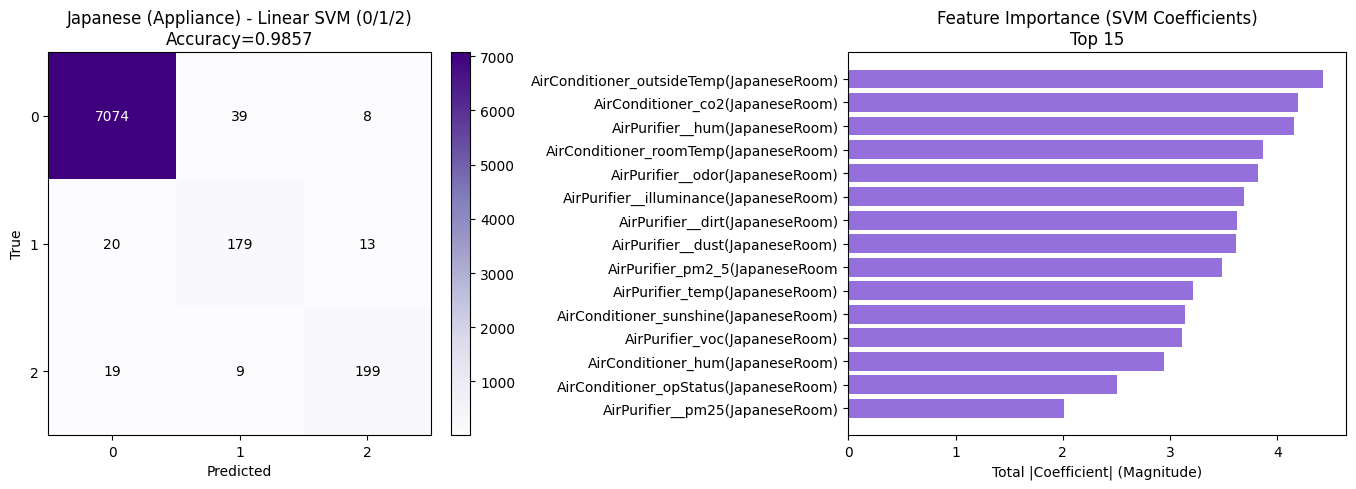


✅ Done.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =========================
# Config
# =========================
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

# 窓幅 (分)
WINS = [5, 10, 15, 20, 25, 30, 60]

TOPK_IMPORTANCE = 15
SEED = 42
BLOCK_MINUTES = 30
TEST_RATIO = 0.30

LABEL_COLS = [
    "Label_Living_Action",
    "Label_Living_Count",
    "Label_Japanese_Count",
    "Label_Japanese_Action",
    "Label_Total_People"
]

# =========================
# Utilities
# =========================
def fix_timestamp_robust(df: pd.DataFrame, col: str) -> pd.Series:
    s = df[col].astype(str)
    if s.iloc[0].startswith("20") and "-" in s.iloc[0]:
        return pd.to_datetime(s, errors="coerce")
    try:
        temp_dates = pd.to_datetime(s, format='%M:%S.%f', errors='coerce')
    except:
        temp_dates = pd.to_datetime(s, errors='coerce')
    if temp_dates.isna().mean() > 0.5:
         temp_dates = pd.to_datetime(s, errors='coerce')
    diff = temp_dates.diff()
    wrap_indices = diff < pd.Timedelta(minutes=-30)
    hours_to_add = wrap_indices.cumsum()
    return temp_dates + pd.to_timedelta(hours_to_add, unit='h')

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]
    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())
    if not out: return pd.DataFrame()
    dfr = pd.concat(out, axis=1).sort_index()
    return safe_ffill(dfr).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

# ---------------------------------------------------------
# Feature Importance Aggregation (Multi-class SVM)
# ---------------------------------------------------------
def aggregate_coefficients_multiclass(feature_names, coefs):
    """
    多クラスSVMの係数 coef_ の形状は (n_classes, n_features) です。
    クラスごとの係数の絶対値を合計して、特徴量全体の重要度とします。
    """
    base_names = []
    # 各特徴量に対し、全クラス分の係数の絶対値を合計する (axis=0)
    # これにより「どのクラスの判別においても影響力が大きい変数」が上位に来ます
    total_impact = np.sum(np.abs(coefs), axis=0)

    pattern = re.compile(r'(_diff|_mean_\d+|_std_\d+|_slope_\d+|_sum_\d+)$')

    for name in feature_names:
        base = pattern.sub('', name)
        base_names.append(base)

    df_imp = pd.DataFrame({'feature': base_names, 'importance': total_impact})
    grouped = df_imp.groupby('feature')['importance'].sum().sort_values(ascending=False)
    return grouped

def plot_cm_and_importance_svm(title, y_true, y_pred, labels, feature_names, coefs, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    fig = plt.figure(figsize=(14, 5))

    # 1. Confusion Matrix
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Purples") # SVMカラー
    ax1.set_title(f"{title}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(labels); ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = "white" if cm[i, j] > cm.max()/2 else "black"
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color=text_color)

    # 2. Aggregated Importance (Coefficients)
    ax2 = plt.subplot(1, 2, 2)
    agg_imp = aggregate_coefficients_multiclass(feature_names, coefs)
    top = agg_imp.head(topk)[::-1]

    ax2.barh(top.index, top.values, color="mediumpurple")
    ax2.set_title(f"Feature Importance (SVM Coefficients)\nTop {topk}")
    ax2.set_xlabel("Total |Coefficient| (Magnitude)")

    plt.tight_layout()
    plt.show()

# =========================
# Feature Engineering
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3: return pd.Series(0.0, index=y.index)
    return (y - y.shift(w)).fillna(0.0) / w

def build_numeric_features(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns: continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)
        feats[c] = s
        feats[f"{c}_diff"] = s.diff().fillna(0.0)
        for w in wins:
            feats[f"{c}_mean_{w}"] = s.rolling(w).mean().fillna(0.0)
            feats[f"{c}_std_{w}"]  = s.rolling(w).std().fillna(0.0)
            feats[f"{c}_slope_{w}"] = _rolling_linreg_slope(s, w)
    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X.loc[:, ~X.columns.duplicated()]

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns: continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}"] = s.rolling(w).sum().fillna(0.0)
    X = pd.DataFrame(feats, index=df.index)
    return X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# =========================
# Main Logic (SVM Multiclass)
# =========================
def run_svm_multiclass(filename: str, room: str, target_col: str, mode: str = "All"):
    """
    mode: "All" or "Appliance"
    target: 0/1/2 (Multiclass)
    """
    print(f"\n📥 Loading {room} ({mode}) data from: {filename} ...")
    try:
        df0 = pd.read_csv(filename, low_memory=False)
    except UnicodeDecodeError:
        df0 = pd.read_csv(filename, low_memory=False, encoding='cp932')

    if TIME_COL not in df0.columns: return
    if target_col not in df0.columns: return

    # Timestamp
    df0[TIME_COL] = fix_timestamp_robust(df0, TIME_COL)
    df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)
    df0 = safe_ffill(df0).fillna(0.0)

    # Resample
    df = resample_1min(df0, RESAMPLE_RULE)

    # Label (0, 1, 2)
    y = pd.to_numeric(df[target_col], errors="coerce").fillna(0).astype(int)
    y = y.apply(lambda x: x if x in [0, 1, 2] else 0)

    # Feature Selection
    all_cols = [c for c in df.columns if c not in LABEL_COLS]

    if mode == "Appliance":
        target_cols = [c for c in all_cols if "AirPurifier" in c or "AirConditioner" in c]
    else:
        target_cols = all_cols

    hum_cols = [c for c in target_cols if "human" in c.lower() or "pir" in c.lower() or "motion" in c.lower()]
    num_cols = [c for c in target_cols if c not in hum_cols]

    print(f"  Features -> Numeric: {len(num_cols)}, Event/Human: {len(hum_cols)}")

    # 特徴量作成
    X_num = build_numeric_features(df, num_cols, WINS)
    X_hum = build_human_features(df, hum_cols, WINS)
    X = pd.concat([X_num, X_hum], axis=1).fillna(0.0)

    # Split
    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_te, y_te = X.iloc[te_idx], y.iloc[te_idx]

    print(f"  Train: {len(X_tr)}, Test: {len(X_te)}")

    # SVM Model (Multiclass)
    # LinearSVCはデフォルトでOne-vs-Rest戦略をとります
    clf = make_pipeline(
        StandardScaler(),
        LinearSVC(
            multi_class='ovr', # 明示的にOne-vs-Restを指定
            random_state=SEED,
            dual=False,
            class_weight='balanced', # 不均衡データ対策
            max_iter=2000
        )
    )

    clf.fit(X_tr, y_tr)
    pred = clf.predict(X_te)

    # Report
    print(f"\n--- Result: {room} [{mode}] (SVM: 0/1/2) ---")
    print(classification_report(y_te, pred, digits=3, zero_division=0))

    # 特徴量重要度
    model = clf.named_steps['linearsvc']
    # model.coef_ のshapeは (3, n_features) になります

    # Plot
    plot_cm_and_importance_svm(
        f"{room} ({mode}) - Linear SVM (0/1/2)",
        y_te, pred, [0, 1, 2],
        X.columns, model.coef_,
        topk=TOPK_IMPORTANCE
    )

# =========================
# Execution
# =========================

# 1. Living Analysis
run_svm_multiclass("/content/リビング.csv", "Living", "Label_Living_Count", mode="All")
run_svm_multiclass("/content/リビング.csv", "Living", "Label_Living_Count", mode="Appliance")

# 2. Japanese Room Analysis
run_svm_multiclass("/content/和室.csv", "Japanese", "Label_Japanese_Count", mode="All")
run_svm_multiclass("/content/和室.csv", "Japanese", "Label_Japanese_Count", mode="Appliance")

print("\n✅ Done.")

Using device: cpu

📥 Loading Living (All) data from: /content/リビング.csv ...
  Train: 17591, Test: 7560
  Class Weights: [ 0.35710517  8.388651   12.423022  ]

🚀 Start Training...
  Epoch 10/50 | Loss: 0.0372 | Val Acc: 0.9694
  Epoch 20/50 | Loss: 0.0145 | Val Acc: 0.9710
  Epoch 30/50 | Loss: 0.0227 | Val Acc: 0.9685
  Epoch 40/50 | Loss: 0.0082 | Val Acc: 0.9708
  Epoch 50/50 | Loss: 0.0227 | Val Acc: 0.9714


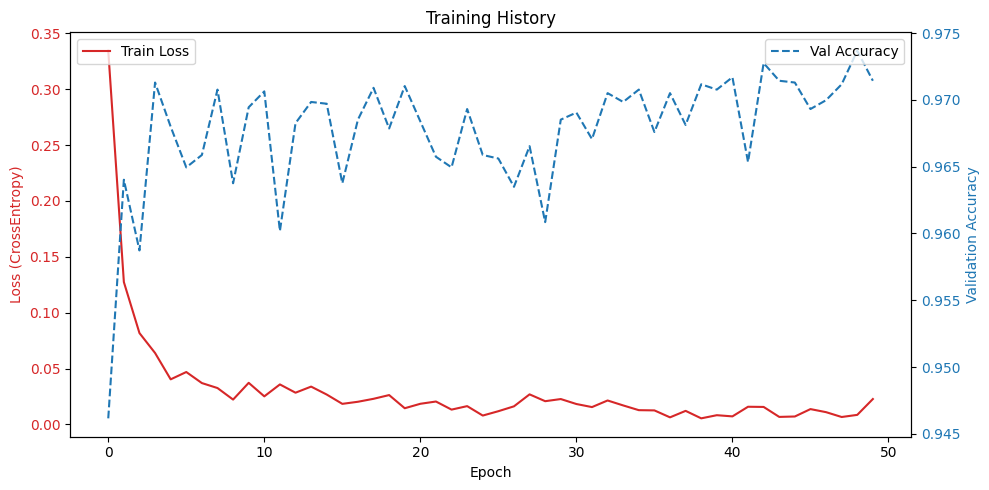


--- Result: Living [All] (Deep Learning: MLP) ---
              precision    recall  f1-score   support

           0      1.000     0.988     0.994      6901
           1      0.733     0.877     0.799       326
           2      0.688     0.721     0.704       333

    accuracy                          0.971      7560
   macro avg      0.807     0.862     0.832      7560
weighted avg      0.974     0.971     0.973      7560



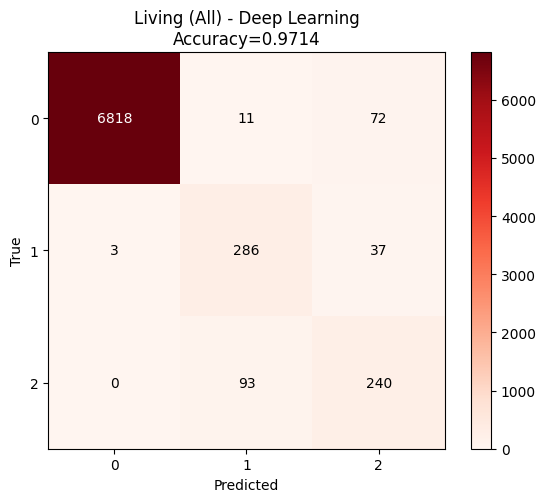

📝 Note: Neural Networks don't provide simple feature importance bars like Random Forest.

📥 Loading Japanese (All) data from: /content/和室.csv ...
  Train: 17527, Test: 7560
  Class Weights: [ 0.34965187 12.5641575  16.55052   ]

🚀 Start Training...
  Epoch 10/50 | Loss: 0.0453 | Val Acc: 0.9862
  Epoch 20/50 | Loss: 0.0156 | Val Acc: 0.9880
  Epoch 30/50 | Loss: 0.0250 | Val Acc: 0.9882
  Epoch 40/50 | Loss: 0.0206 | Val Acc: 0.9876
  Epoch 50/50 | Loss: 0.0140 | Val Acc: 0.9907


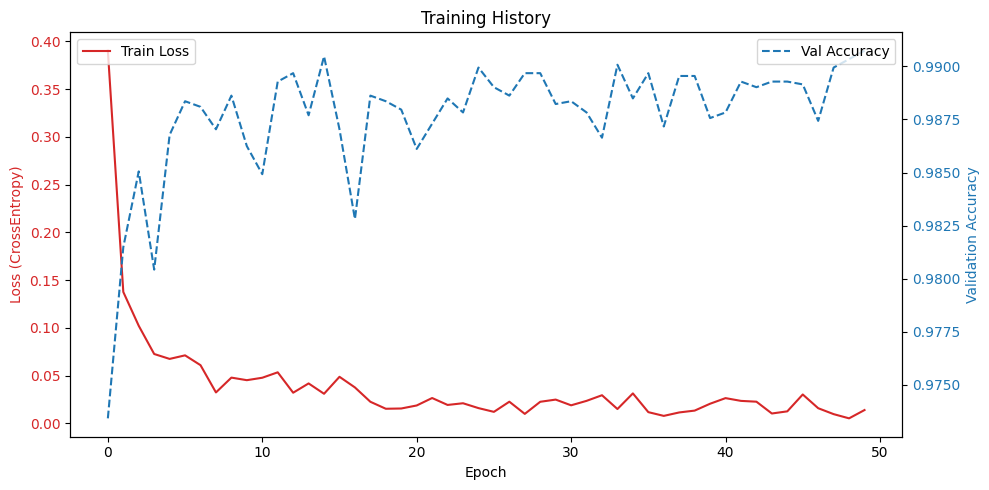


--- Result: Japanese [All] (Deep Learning: MLP) ---
              precision    recall  f1-score   support

           0      0.998     0.995     0.996      7121
           1      0.806     0.943     0.870       212
           2      0.976     0.894     0.933       227

    accuracy                          0.991      7560
   macro avg      0.927     0.944     0.933      7560
weighted avg      0.992     0.991     0.991      7560



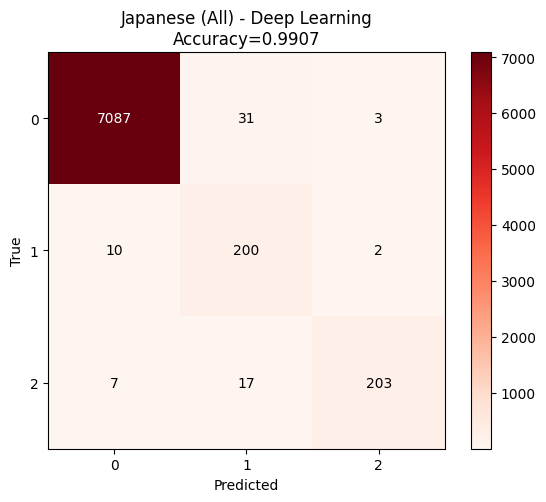

📝 Note: Neural Networks don't provide simple feature importance bars like Random Forest.

✅ Done.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =========================
# Config
# =========================
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"
WINS = [5, 10, 15, 20, 25, 30, 60]

# Deep Learning Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 50   # 学習回数（データ量に応じて調整）
SEED = 42
BLOCK_MINUTES = 30
TEST_RATIO = 0.30

# デバイス設定 (GPUがあれば使う)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 再現性のためのシード固定
torch.manual_seed(SEED)
np.random.seed(SEED)

LABEL_COLS = [
    "Label_Living_Action",
    "Label_Living_Count",
    "Label_Japanese_Count",
    "Label_Japanese_Action",
    "Label_Total_People"
]

# =========================
# Utilities
# =========================
def fix_timestamp_robust(df: pd.DataFrame, col: str) -> pd.Series:
    s = df[col].astype(str)
    if s.iloc[0].startswith("20") and "-" in s.iloc[0]:
        return pd.to_datetime(s, errors="coerce")
    try:
        temp_dates = pd.to_datetime(s, format='%M:%S.%f', errors='coerce')
    except:
        temp_dates = pd.to_datetime(s, errors='coerce')
    if temp_dates.isna().mean() > 0.5:
         temp_dates = pd.to_datetime(s, errors='coerce')
    diff = temp_dates.diff()
    wrap_indices = diff < pd.Timedelta(minutes=-30)
    hours_to_add = wrap_indices.cumsum()
    return temp_dates + pd.to_timedelta(hours_to_add, unit='h')

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]
    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())
    if not out: return pd.DataFrame()
    dfr = pd.concat(out, axis=1).sort_index()
    return safe_ffill(dfr).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

def plot_training_history(train_losses, val_accuracies):
    """学習曲線のプロット"""
    fig, ax1 = plt.subplots(figsize=(10, 5))

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (CrossEntropy)', color=color)
    ax1.plot(train_losses, color=color, label='Train Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Validation Accuracy', color=color)
    ax2.plot(val_accuracies, color=color, linestyle='--', label='Val Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    plt.title("Training History")
    fig.tight_layout()
    plt.show()

def plot_cm_dnn(title, y_true, y_pred, labels):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation="nearest", cmap="Reds") # Deep Learningっぽく赤系
    plt.title(f"{title}\nAccuracy={acc:.4f}")
    plt.colorbar()
    tick = np.arange(len(labels))
    plt.xticks(tick, labels); plt.yticks(tick, labels)
    plt.xlabel("Predicted"); plt.ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = "white" if cm[i, j] > cm.max()/2 else "black"
            plt.text(j, i, str(cm[i, j]), ha="center", va="center", color=text_color)
    plt.tight_layout()
    plt.show()

# =========================
# Feature Engineering
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3: return pd.Series(0.0, index=y.index)
    return (y - y.shift(w)).fillna(0.0) / w

def build_numeric_features(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns: continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)
        feats[c] = s
        feats[f"{c}_diff"] = s.diff().fillna(0.0)
        for w in wins:
            feats[f"{c}_mean_{w}"] = s.rolling(w).mean().fillna(0.0)
            feats[f"{c}_std_{w}"]  = s.rolling(w).std().fillna(0.0)
            feats[f"{c}_slope_{w}"] = _rolling_linreg_slope(s, w)
    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X.loc[:, ~X.columns.duplicated()]

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns: continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}"] = s.rolling(w).sum().fillna(0.0)
    X = pd.DataFrame(feats, index=df.index)
    return X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# =========================
# Deep Learning Model (MLP)
# =========================
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        # 3層のニューラルネットワーク
        self.network = nn.Sequential(
            # Layer 1
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),  # 学習を安定させる
            nn.ReLU(),
            nn.Dropout(0.3),      # 過学習を防ぐ

            # Layer 2
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            # Output Layer
            nn.Linear(64, output_dim)
            # ※ CrossEntropyLossを使う場合、最後にSoftmaxは不要(Loss関数に含まれるため)
        )

    def forward(self, x):
        return self.network(x)

# =========================
# Main Logic
# =========================
def run_dnn_analysis(filename: str, room: str, target_col: str, mode: str = "All"):
    print(f"\n📥 Loading {room} ({mode}) data from: {filename} ...")
    try:
        df0 = pd.read_csv(filename, low_memory=False)
    except UnicodeDecodeError:
        df0 = pd.read_csv(filename, low_memory=False, encoding='cp932')

    if TIME_COL not in df0.columns: return
    if target_col not in df0.columns: return

    # Timestamp & Resample
    df0[TIME_COL] = fix_timestamp_robust(df0, TIME_COL)
    df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)
    df0 = safe_ffill(df0).fillna(0.0)
    df = resample_1min(df0, RESAMPLE_RULE)

    # Label (0, 1, 2)
    y = pd.to_numeric(df[target_col], errors="coerce").fillna(0).astype(int)
    y = y.apply(lambda x: x if x in [0, 1, 2] else 0)

    # Feature Selection
    all_cols = [c for c in df.columns if c not in LABEL_COLS]
    if mode == "Appliance":
        target_cols = [c for c in all_cols if "AirPurifier" in c or "AirConditioner" in c]
    else:
        target_cols = all_cols

    hum_cols = [c for c in target_cols if "human" in c.lower() or "pir" in c.lower() or "motion" in c.lower()]
    num_cols = [c for c in target_cols if c not in hum_cols]

    # Feature Engineering
    X_num = build_numeric_features(df, num_cols, WINS)
    X_hum = build_human_features(df, hum_cols, WINS)
    X_df = pd.concat([X_num, X_hum], axis=1).fillna(0.0)

    # Data Split
    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X_df, y, groups=groups))

    X_train_raw, y_train_raw = X_df.iloc[tr_idx], y.iloc[tr_idx]
    X_test_raw, y_test_raw = X_df.iloc[te_idx], y.iloc[te_idx]

    # ==========================================
    # Deep Learning Specific Preprocessing
    # ==========================================

    # 1. Scaling (StandardScaler) - NNには必須
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_raw)
    X_test = scaler.transform(X_test_raw)

    # 2. Convert to PyTorch Tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_raw.values, dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test_raw.values, dtype=torch.long).to(device)

    # 3. DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # 4. Class Weight Calculation (不均衡データ対策)
    # 0が多すぎるため、少ないクラスのLossを大きく評価するように重みを計算
    class_counts = np.bincount(y_train_raw)
    # 重み = 全体数 / (クラス数 * 各クラスの出現数)
    weights = len(y_train_raw) / (3 * class_counts)
    class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

    print(f"  Train: {len(X_train)}, Test: {len(X_test)}")
    print(f"  Class Weights: {class_weights.cpu().numpy()}")

    # ==========================================
    # Model Setup
    # ==========================================
    input_dim = X_train.shape[1]
    output_dim = 3 # 0, 1, 2

    model = SimpleNN(input_dim, output_dim).to(device)

    # Loss Function & Optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights) # 損失関数
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # 最適化手法

    # ==========================================
    # Training Loop
    # ==========================================
    print("\n🚀 Start Training...")
    train_losses = []
    val_accuracies = []

    for epoch in range(EPOCHS):
        model.train() # 学習モード
        epoch_loss = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()           # 勾配初期化
            outputs = model(X_batch)        # 順伝播
            loss = criterion(outputs, y_batch) # 損失計算
            loss.backward()                 # 逆伝播
            optimizer.step()                # パラメータ更新

            epoch_loss += loss.item()

        # Validation (Epochごと)
        model.eval() # 評価モード
        with torch.no_grad():
            outputs_val = model(X_test_tensor)
            _, predicted_val = torch.max(outputs_val, 1)
            val_acc = accuracy_score(y_test_tensor.cpu(), predicted_val.cpu())

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        val_accuracies.append(val_acc)

        if (epoch+1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Plot History
    plot_training_history(train_losses, val_accuracies)

    # ==========================================
    # Final Evaluation
    # ==========================================
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predictions = torch.max(outputs, 1)

    pred_cpu = predictions.cpu().numpy()
    y_test_cpu = y_test_tensor.cpu().numpy()

    print(f"\n--- Result: {room} [{mode}] (Deep Learning: MLP) ---")
    print(classification_report(y_test_cpu, pred_cpu, digits=3, zero_division=0))

    # Confusion Matrix
    plot_cm_dnn(f"{room} ({mode}) - Deep Learning", y_test_cpu, pred_cpu, [0, 1, 2])

    print("📝 Note: Neural Networks don't provide simple feature importance bars like Random Forest.")

# =========================
# Execution
# =========================

# 1. Living
run_dnn_analysis("/content/リビング.csv", "Living", "Label_Living_Count", mode="All")
# run_dnn_analysis("リビング.csv", "Living", "Label_Living_Count", mode="Appliance")

# 2. Japanese
run_dnn_analysis("/content/和室.csv", "Japanese", "Label_Japanese_Count", mode="All")

print("\n✅ Done.")